# Train using balanced subsets of data - 448 Redux

### Findings
- Dataset has propensity for flucting validation loss, even with increated dropotuand reduced model layers
- Training at very low LR (1e4) gives more stable results, bult ultimately sub-optimal final results
- Better results achieved using higher LR, and using SaveModelCallback to capture local minima
- Combining multiple top learners gives significantly better results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import collections

In [3]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
import os
import pickle

import scipy
from scipy.stats import gmean, hmean

In [4]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, \
                          get_accuracy, analyze_confidence, accuracy_vs_threshold, \
                          show_incremental_accuracy,  analyze_low_confidence, \
                          plot_confusion_matrix_thresh, get_val_stats, model_cutter

In [5]:
#from pneumonia_loaders import *

In [6]:
from pneumonia_loaders import show_categories
from pneumonia_new_loader import get_db

In [7]:
from helpers import get_best_stats, show_results, show_results
from helpers import StatsRepo, stats_repo_unit_test
from helpers import _get_learner, _get_interp, analyze_interp, _do_train

# Config

In [8]:
model = models.resnet18
size=448
n_samples=1000    # total number of training samples

In [9]:
all_bs = {224:31, 448:31, 896:7}

In [10]:
data_base = Path()/'data'
model_base = Path('D:/Users/Doug/Models/chest_xray')

all_bs = {224:31, 448:31, 896:7}

In [11]:
prefix = f'18_{size}'
short_prefix = f'18_{size}'

data_subdir  = f'chest_xray_{size}'
model_subdir = f'18_{size}'

if size in [224, 448, 896]:
    path = data_base/data_subdir
    model_dir = (model_base/model_subdir).absolute()
    bs = all_bs[size]
else:
    raise Exception('Unknown size')

In [12]:
bs, model_dir

(31, WindowsPath('D:/Users/Doug/Models/chest_xray/18_448'))

In [13]:
path.ls()

[WindowsPath('data/chest_xray_448/test'),
 WindowsPath('data/chest_xray_448/train'),
 WindowsPath('data/chest_xray_448/val')]

# Code

In [14]:
def my_transforms():
    tfms = get_transforms(do_flip=True, flip_vert=False,
                          max_zoom=1.3, max_lighting=0.3)
    return tfms

In [15]:
def get_params(all_lr=[1e-2, 3e-3, 1e-3], all_cycles=[1,2,4, 8]):
    global short_prefix
    for lr in all_lr:
        for cycles in all_cycles:
            key = f'{short_prefix}_lr_{lr}_cyc_{cycles}'
            yield key, {'cycles':cycles, 'max_lr':lr}

In [16]:
def restore_learner(name, ps=0.5, compute_baseline=True):
    learn = get_learner(ps=ps)
    learn.load(name)
    
    if compute_baseline:
        base = learn.svalidate()
        base = {'loss': base[0], 'error_rate': float(base[1]), 'accuracy': float(base[2])}
    else:
        base = None
    return learn, base

def refine_learner(name, ps=0.8, lr=1e-6, cycles=16, **kwargs):
    learn, base = restore_learner(name, ps=ps)
    print('base:', base)
    learn.unfreeze()
    learn.fit_one_cycle(cycles, max_lr=slice(lr,lr),
                        callbacks=[SaveModelCallback(learn, every='improvement', 
                                   monitor='accuracy', name='best')], **kwargs)
    stats = get_best_stats(learn)
    
    if stats['error_rate'] < base['error_rate']:
        new_name = f'{name}_r_lr{lr}_c{cycles}_ps{ps}'
        print('keeping:', stats)
        return learn, stats, new_name
    else:
        print('ignoring:', stats)
        return None, None, None

# Additional Configuration

###### Initialize stats repo (use prior contents if available)

In [17]:
all_stats = StatsRepo(prefix, force_init=False, verbose=True)

restored stats from: stats\18_448_stats.p


###### Get Training/Validation/Test dataset for  Normal / Viral / Bacterial

In [18]:
#data = get_db_np(path, size=size, scale=10, tfms=my_transforms())
data, data_test = get_db(path, kind='nvb', n_samples=n_samples, scale=1, include_test=True,
                  size=size, bs=bs, tfms=my_transforms())
print('Training set:')
show_categories(data.train_ds.y)
print('\nValidation set:')
show_categories(data.valid_ds.y)
print('\nTest set:')
show_categories(data_test.valid_ds.y)

Training set:
  bacteria  :  1000     33.3%
  normal    :  1000     33.3%
  virus     :  1000     33.3%
  Total     :  3000

Validation set:
  bacteria  :    74     33.3%
  normal    :    74     33.3%
  virus     :    74     33.3%
  Total     :   222

Test set:
  bacteria  :    74     33.3%
  normal    :    74     33.3%
  virus     :    74     33.3%
  Total     :   222


In [19]:
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
virus,normal,normal,normal,bacteria
Path: data\chest_xray_448;

Valid: LabelList (222 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
bacteria,virus,bacteria,virus,bacteria
Path: data\chest_xray_448;

Test: None

###### Define configuration specific functions and initialize stats repo (use prior contents if available)

In [20]:
get_learner = partial(_get_learner, db=data, model=model, model_dir=model_dir)
get_learner_test = partial(_get_learner, db=data_test, model=model, model_dir=model_dir)

get_interp = partial(_get_interp, get_learner=get_learner)
get_interp_test = partial(_get_interp, get_learner=get_learner_test)

do_train = partial(_do_train, get_learner=get_learner, stats_repo=all_stats)

In [21]:
import scipy
from scipy.stats import gmean, hmean

def compute_acc(preds, y_true):
    yy = np.argmax(preds, axis=-1)
    return np.mean(yy==y_true)
    

def combine_predictions(all_interp):
    y_true = to_np(all_interp[0][1].y_true)
    all_preds = np.stack([to_np(interp.preds) for _, interp in all_interp])
    
    preds = np.mean(all_preds, axis=0)
    acc_m = compute_acc(preds, y_true) 
    
    preds = np.median(all_preds, axis=0)
    acc_med = compute_acc(preds, y_true)
    
    preds = gmean(all_preds, axis=0)
    acc_g = compute_acc(preds, y_true)
    
    preds = hmean(all_preds, axis=0)
    acc_h = compute_acc(preds, y_true)
    
    print(f'accuracy -- mean: {acc_m:0.3f}   median: {acc_med:0.3f}   gmean: {acc_g:0.3f}   hmean: {acc_h:0.3f}')
    return acc_m, acc_med, acc_g, acc_h

## Various Development Tests
Disabled by default

# Analysis

In [22]:
# barrier after initialization for notebook restart
assert False

AssertionError: 

### Basic LR Finder runs

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03 
Min loss divided by 10: 8.32E-03
Min numerical gradient: 1.20E-03  (smoothed)
Min numerical gradient: 7.59E-03
Min loss divided by 10: 4.79E-03


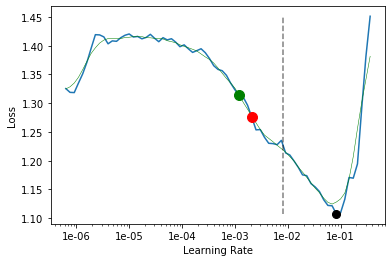

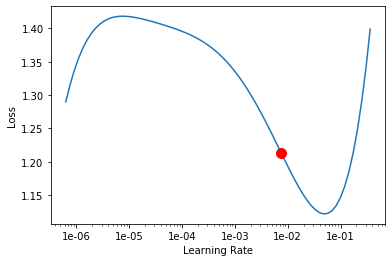

In [23]:
learn = get_learner()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

## Explore Baseline

18_448_lr_0.01_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.729246,0.811672,0.279279,0.720721,00:45


Better model found at epoch 0 with accuracy value: 0.7207207083702087.


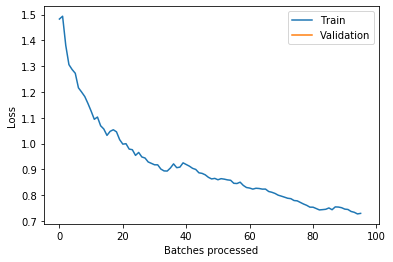

18_448_lr_0.01_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.776040,1.247906,0.409910,0.590090,00:44
1,0.604958,0.872984,0.279279,0.720721,00:44


Better model found at epoch 0 with accuracy value: 0.5900900959968567.
Better model found at epoch 1 with accuracy value: 0.7207207083702087.


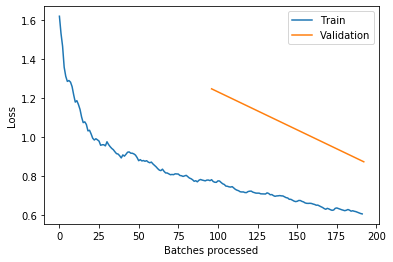

18_448_lr_0.01_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.761181,1.174047,0.360360,0.639640,00:44
1,0.655643,0.599549,0.220721,0.779279,00:44
2,0.559502,0.810036,0.337838,0.662162,00:43
3,0.487580,0.714629,0.202703,0.797297,00:44


Better model found at epoch 0 with accuracy value: 0.6396396160125732.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 3 with accuracy value: 0.7972972989082336.


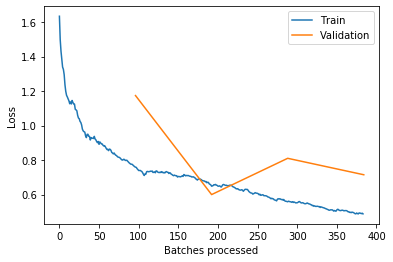

18_448_lr_0.01_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.792187,0.668772,0.202703,0.797297,00:44
1,0.674788,0.967946,0.274775,0.725225,00:44
2,0.642265,0.630459,0.193694,0.806306,00:44
3,0.587280,1.027678,0.328829,0.671171,00:43
4,0.534444,0.928169,0.373874,0.626126,00:44
5,0.524107,0.839943,0.247748,0.752252,00:44
6,0.473074,0.762167,0.216216,0.783784,00:44
7,0.454382,0.829269,0.238739,0.761261,00:44


Better model found at epoch 0 with accuracy value: 0.7972972989082336.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.


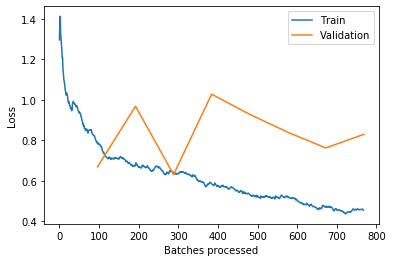

18_448_lr_0.003_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.760447,0.743425,0.211712,0.788288,00:44


Better model found at epoch 0 with accuracy value: 0.7882882952690125.


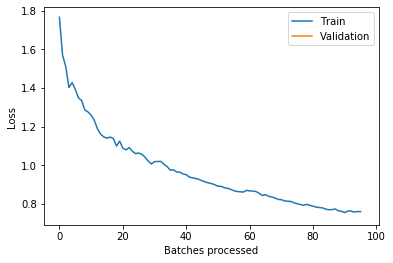

18_448_lr_0.003_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.758429,0.888761,0.279279,0.720721,00:44
1,0.614771,0.688792,0.184685,0.815315,00:44


Better model found at epoch 0 with accuracy value: 0.7207207083702087.
Better model found at epoch 1 with accuracy value: 0.815315306186676.


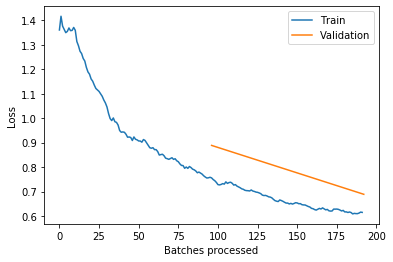

18_448_lr_0.003_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.834054,0.621984,0.202703,0.797297,00:44
1,0.638165,1.015893,0.315315,0.684685,00:43
2,0.561852,0.840449,0.252252,0.747748,00:43
3,0.521363,0.872300,0.283784,0.716216,00:44


Better model found at epoch 0 with accuracy value: 0.7972972989082336.


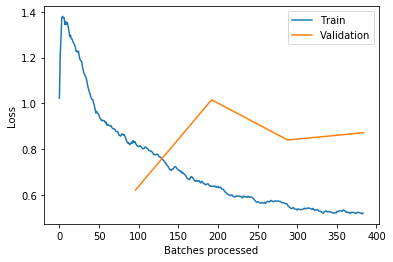

18_448_lr_0.003_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.824284,0.814117,0.279279,0.720721,00:44
1,0.695955,0.862298,0.324324,0.675676,00:44
2,0.591599,0.732404,0.193694,0.806306,00:44
3,0.556999,0.752639,0.234234,0.765766,00:44
4,0.506699,0.538066,0.144144,0.855856,00:44
5,0.494008,0.701317,0.193694,0.806306,00:44
6,0.457746,0.879408,0.225225,0.774775,00:43
7,0.439393,0.823566,0.211712,0.788288,00:44


Better model found at epoch 0 with accuracy value: 0.7207207083702087.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 4 with accuracy value: 0.8558558821678162.


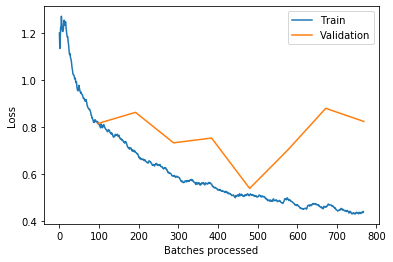

18_448_lr_0.001_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.821821,0.711962,0.243243,0.756757,00:43


Better model found at epoch 0 with accuracy value: 0.7567567825317383.


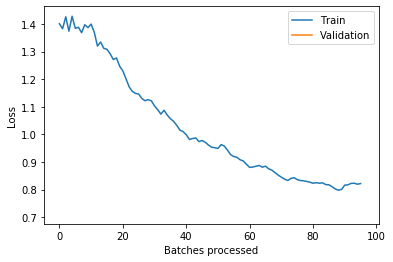

18_448_lr_0.001_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.849817,0.676537,0.211712,0.788288,00:43
1,0.695036,0.681125,0.184685,0.815315,00:43


Better model found at epoch 0 with accuracy value: 0.7882882952690125.
Better model found at epoch 1 with accuracy value: 0.815315306186676.


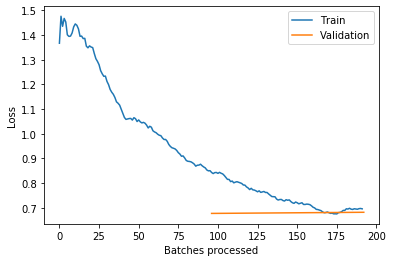

18_448_lr_0.001_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.859083,0.666070,0.225225,0.774775,00:44
1,0.689396,0.737142,0.238739,0.761261,00:43
2,0.633333,0.726835,0.207207,0.792793,00:44
3,0.592741,0.737491,0.207207,0.792793,00:44


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.792792797088623.


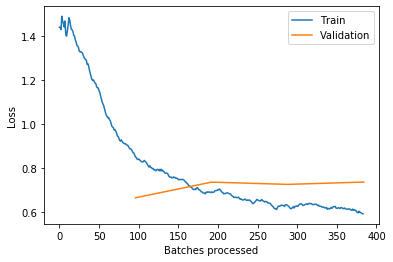

18_448_lr_0.001_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.941201,0.769794,0.283784,0.716216,00:44
1,0.744438,0.710277,0.247748,0.752252,00:44
2,0.634985,0.722068,0.193694,0.806306,00:43
3,0.583529,0.673653,0.180180,0.819820,00:44
4,0.552948,0.737300,0.207207,0.792793,00:43
5,0.524503,0.675333,0.198198,0.801802,00:44
6,0.491752,0.723436,0.193694,0.806306,00:44
7,0.480963,0.634083,0.162162,0.837838,00:44


Better model found at epoch 0 with accuracy value: 0.7162162065505981.
Better model found at epoch 1 with accuracy value: 0.7522522807121277.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.
Better model found at epoch 7 with accuracy value: 0.837837815284729.


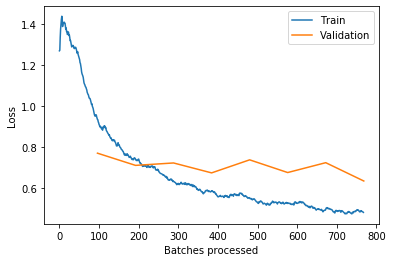

saved stats to: stats\18_448_stats.p


In [24]:
for key, params in get_params():
    do_train(key, **params)
all_stats.save()

18_448_lr_0.0003_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.922538,0.704267,0.256757,0.743243,00:44


Better model found at epoch 0 with accuracy value: 0.7432432174682617.


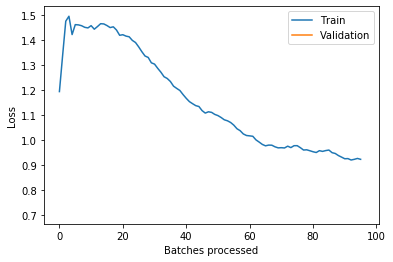

18_448_lr_0.0003_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.911429,0.634949,0.229730,0.770270,00:44
1,0.769128,0.586374,0.225225,0.774775,00:44


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.


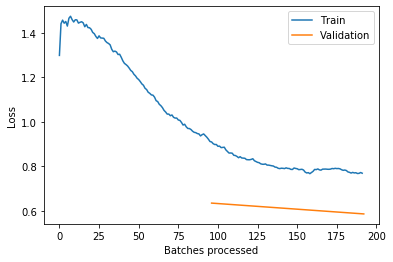

18_448_lr_0.0003_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.031524,0.763100,0.306306,0.693694,00:44
1,0.804640,0.662206,0.234234,0.765766,00:43
2,0.711078,0.675051,0.202703,0.797297,00:44
3,0.687540,0.631274,0.198198,0.801802,00:44


Better model found at epoch 0 with accuracy value: 0.6936936974525452.
Better model found at epoch 1 with accuracy value: 0.7657657861709595.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.8018018007278442.


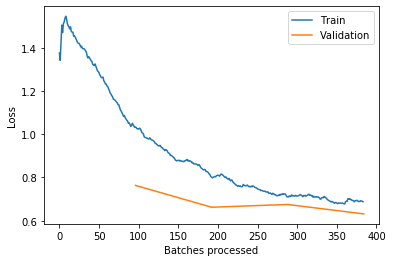

18_448_lr_0.0003_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.244716,0.834895,0.382883,0.617117,00:43
1,0.885341,0.661882,0.225225,0.774775,00:44
2,0.777415,0.696151,0.234234,0.765766,00:43
3,0.696449,0.665769,0.207207,0.792793,00:43
4,0.655549,0.654806,0.198198,0.801802,00:44
5,0.635804,0.715031,0.225225,0.774775,00:43
6,0.605193,0.681038,0.198198,0.801802,00:43
7,0.589134,0.706598,0.216216,0.783784,00:43


Better model found at epoch 0 with accuracy value: 0.6171171069145203.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.
Better model found at epoch 3 with accuracy value: 0.792792797088623.
Better model found at epoch 4 with accuracy value: 0.8018018007278442.


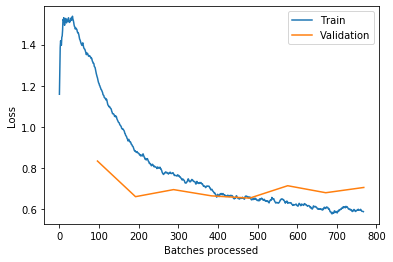

18_448_lr_0.0001_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.047759,0.751913,0.283784,0.716216,00:44


Better model found at epoch 0 with accuracy value: 0.7162162065505981.


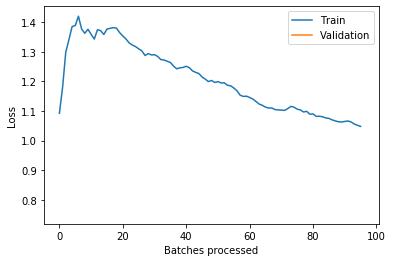

18_448_lr_0.0001_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.144636,0.791799,0.369369,0.630631,00:44
1,0.909291,0.720747,0.310811,0.689189,00:43


Better model found at epoch 0 with accuracy value: 0.630630612373352.
Better model found at epoch 1 with accuracy value: 0.6891891956329346.


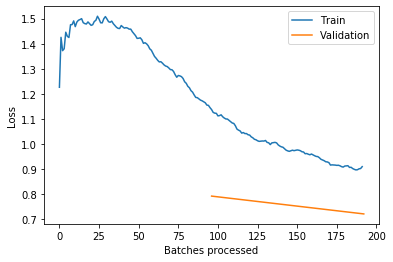

18_448_lr_0.0001_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.277623,0.966482,0.441441,0.558559,00:44
1,0.953248,0.747084,0.279279,0.720721,00:44
2,0.862660,0.701371,0.243243,0.756757,00:44
3,0.804630,0.713461,0.238739,0.761261,00:44


Better model found at epoch 0 with accuracy value: 0.5585585832595825.
Better model found at epoch 1 with accuracy value: 0.7207207083702087.
Better model found at epoch 2 with accuracy value: 0.7567567825317383.
Better model found at epoch 3 with accuracy value: 0.7612612843513489.


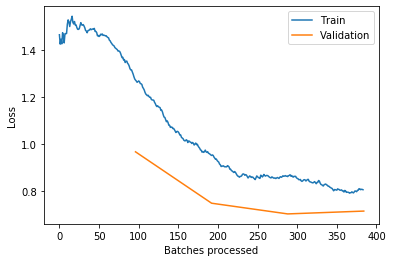

18_448_lr_0.0001_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.407624,0.975244,0.504505,0.495495,00:44
1,1.064160,0.737026,0.274775,0.725225,00:45
2,0.889557,0.715900,0.274775,0.725225,00:44
3,0.836535,0.693634,0.256757,0.743243,00:44
4,0.790192,0.651233,0.243243,0.756757,00:43
5,0.751605,0.677340,0.238739,0.761261,00:44
6,0.734294,0.664321,0.238739,0.761261,00:43
7,0.730378,0.693039,0.238739,0.761261,00:44


Better model found at epoch 0 with accuracy value: 0.4954954981803894.
Better model found at epoch 1 with accuracy value: 0.7252252101898193.
Better model found at epoch 3 with accuracy value: 0.7432432174682617.
Better model found at epoch 4 with accuracy value: 0.7567567825317383.
Better model found at epoch 5 with accuracy value: 0.7612611651420593.
Better model found at epoch 6 with accuracy value: 0.7612612843513489.


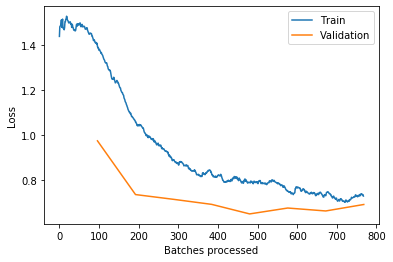

saved stats to: stats\18_448_stats.p


In [25]:
for key, params in get_params(all_lr=[3e-4, 1e-4]):
    do_train(key, **params)
all_stats.save()

In [26]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.144  med: 0.209   Loss -- best: 0.538  med: 0.697

18_448_lr_0.003_cyc_8  error_rate: 0.144   accuracy: 0.856   loss:0.5381
18_448_lr_0.001_cyc_8  error_rate: 0.162   accuracy: 0.838   loss:0.6341
18_448_lr_0.003_cyc_2  error_rate: 0.185   accuracy: 0.815   loss:0.6888
18_448_lr_0.001_cyc_2  error_rate: 0.185   accuracy: 0.815   loss:0.6811
18_448_lr_0.01_cyc_8  error_rate: 0.194   accuracy: 0.806   loss:0.6305
18_448_lr_0.0003_cyc_4  error_rate: 0.198   accuracy: 0.802   loss:0.6313
18_448_lr_0.0003_cyc_8  error_rate: 0.198   accuracy: 0.802   loss:0.6548
18_448_lr_0.01_cyc_4  error_rate: 0.203   accuracy: 0.797   loss:0.7146
18_448_lr_0.003_cyc_4  error_rate: 0.203   accuracy: 0.797   loss:0.6220
18_448_lr_0.001_cyc_4  error_rate: 0.207   accuracy: 0.793   loss:0.7268


18_448_lr_0.03_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.856240,1.035132,0.423423,0.576577,00:44


Better model found at epoch 0 with accuracy value: 0.5765765905380249.


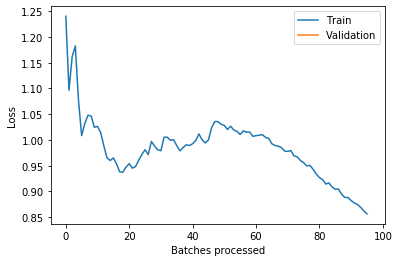

18_448_lr_0.03_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.927762,0.890693,0.270270,0.729730,00:43
1,0.709900,0.692766,0.171171,0.828829,00:43


Better model found at epoch 0 with accuracy value: 0.7297297120094299.
Better model found at epoch 1 with accuracy value: 0.8288288116455078.


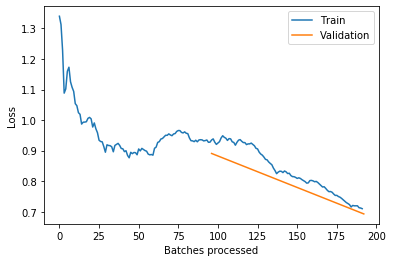

18_448_lr_0.03_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.892592,1.432367,0.450450,0.549550,00:43
1,0.801335,0.648657,0.207207,0.792793,00:44
2,0.631657,1.377075,0.436937,0.563063,00:44
3,0.510705,0.585462,0.157658,0.842342,00:44


Better model found at epoch 0 with accuracy value: 0.5495495200157166.
Better model found at epoch 1 with accuracy value: 0.792792797088623.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.


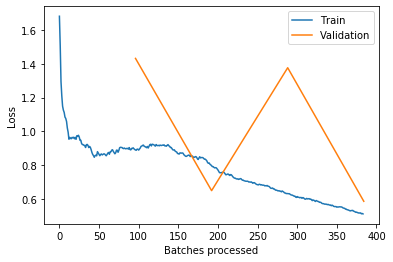

18_448_lr_0.03_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.750142,1.915773,0.603604,0.396396,00:43
1,0.788161,0.731512,0.283784,0.716216,00:44
2,0.725601,0.621099,0.234234,0.765766,00:44
3,0.684192,0.769866,0.373874,0.626126,00:44
4,0.606423,1.729927,0.585586,0.414414,00:44
5,0.570180,0.444636,0.126126,0.873874,00:43
6,0.509243,0.584562,0.148649,0.851351,00:44
7,0.470520,0.616175,0.153153,0.846847,00:44


Better model found at epoch 0 with accuracy value: 0.3963963985443115.
Better model found at epoch 1 with accuracy value: 0.7162162065505981.
Better model found at epoch 2 with accuracy value: 0.7657657861709595.
Better model found at epoch 5 with accuracy value: 0.8738738894462585.


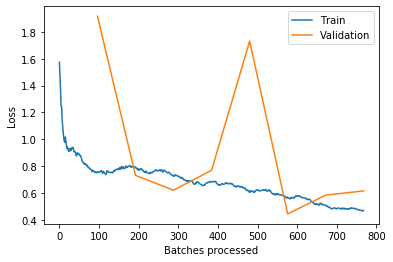

18_448_lr_0.1_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.322497,2.131504,0.567568,0.432432,00:43


Better model found at epoch 0 with accuracy value: 0.4324324429035187.


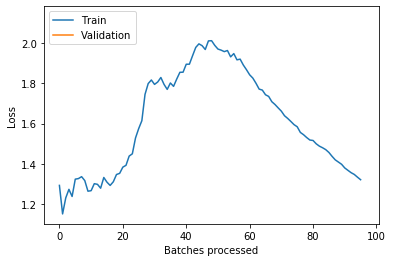

18_448_lr_0.1_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.878010,2.781986,0.463964,0.536036,00:44
1,1.046417,0.739420,0.225225,0.774775,00:44


Better model found at epoch 0 with accuracy value: 0.5360360145568848.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.


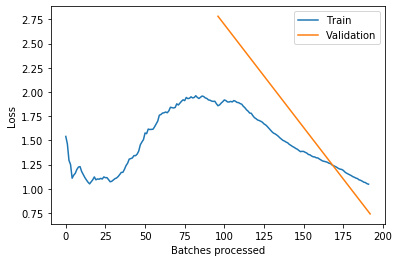

18_448_lr_0.1_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.259705,2.720810,0.752252,0.247748,00:44
1,1.366064,2.146399,0.518018,0.481982,00:44
2,0.907841,0.910168,0.495495,0.504505,00:44
3,0.666216,1.194715,0.207207,0.792793,00:44


Better model found at epoch 0 with accuracy value: 0.2477477490901947.
Better model found at epoch 1 with accuracy value: 0.4819819927215576.
Better model found at epoch 2 with accuracy value: 0.5045045018196106.
Better model found at epoch 3 with accuracy value: 0.792792797088623.


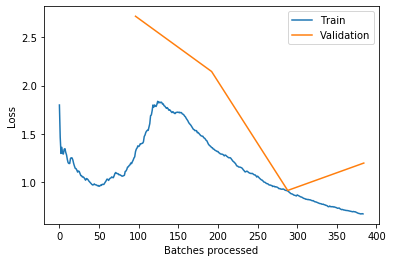

18_448_lr_0.1_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.851355,1.559190,0.500000,0.500000,00:43
1,1.478854,1.521352,0.585586,0.414414,00:43
2,1.878562,5.208910,0.657658,0.342342,00:44
3,1.236431,1.984516,0.581081,0.418919,00:44
4,1.026666,0.781800,0.360360,0.639640,00:43
5,0.737735,3.723295,0.432432,0.567568,00:43
6,0.632138,0.656576,0.166667,0.833333,00:44
7,0.578062,0.653128,0.166667,0.833333,00:44


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 4 with accuracy value: 0.6396396160125732.
Better model found at epoch 6 with accuracy value: 0.8333333134651184.


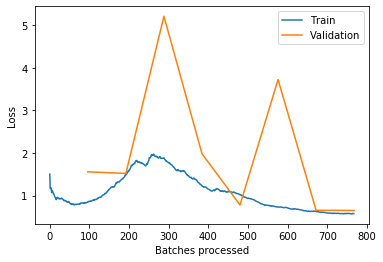

saved stats to: stats\18_448_stats.p


In [27]:
for key, params in get_params(all_lr=[3e-2, 1e-1]):
    do_train(key, **params)
all_stats.save()

In [28]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.126  med: 0.207   Loss -- best: 0.445  med: 0.699

18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.003_cyc_8  error_rate: 0.144   accuracy: 0.856   loss:0.5381
18_448_lr_0.03_cyc_4  error_rate: 0.158   accuracy: 0.842   loss:0.5855
18_448_lr_0.001_cyc_8  error_rate: 0.162   accuracy: 0.838   loss:0.6341
18_448_lr_0.1_cyc_8   error_rate: 0.167   accuracy: 0.833   loss:0.6531
18_448_lr_0.03_cyc_2  error_rate: 0.171   accuracy: 0.829   loss:0.6928
18_448_lr_0.003_cyc_2  error_rate: 0.185   accuracy: 0.815   loss:0.6888
18_448_lr_0.001_cyc_2  error_rate: 0.185   accuracy: 0.815   loss:0.6811
18_448_lr_0.01_cyc_8  error_rate: 0.194   accuracy: 0.806   loss:0.6305
18_448_lr_0.0003_cyc_4  error_rate: 0.198   accuracy: 0.802   loss:0.6313


18_448_lr_0.001_cyc_16_ps_0.5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.085167,0.775517,0.292793,0.707207,00:44
1,0.825577,0.658623,0.220721,0.779279,00:43
2,0.716087,0.720495,0.207207,0.792793,00:44
3,0.637282,0.671592,0.207207,0.792793,00:43
4,0.594708,0.661547,0.211712,0.788288,00:44
5,0.550633,0.639601,0.175676,0.824324,00:43
6,0.512628,0.987140,0.270270,0.729730,00:44
7,0.498785,0.831314,0.216216,0.783784,00:44
8,0.504851,0.840221,0.216216,0.783784,00:44
9,0.486480,0.679413,0.175676,0.824324,00:44


Better model found at epoch 0 with accuracy value: 0.707207202911377.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 2 with accuracy value: 0.792792797088623.
Better model found at epoch 5 with accuracy value: 0.8243243098258972.
Better model found at epoch 15 with accuracy value: 0.837837815284729.


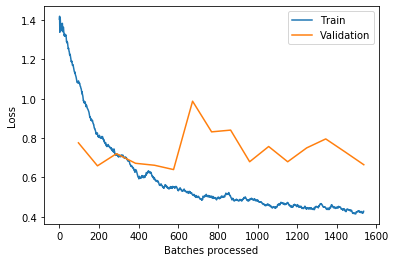

18_448_lr_0.001_cyc_16_ps_0.8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.659412,0.698610,0.252252,0.747748,00:44
1,1.228902,0.607999,0.207207,0.792793,00:44
2,0.966924,0.625630,0.202703,0.797297,00:44
3,0.827501,0.657134,0.216216,0.783784,00:44
4,0.714555,0.683306,0.189189,0.810811,00:44
5,0.654995,0.683944,0.180180,0.819820,00:44
6,0.612333,0.653239,0.175676,0.824324,00:44
7,0.568756,0.652741,0.171171,0.828829,00:43
8,0.563847,0.681652,0.184685,0.815315,00:44
9,0.531133,0.695896,0.207207,0.792793,00:44


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 1 with accuracy value: 0.792792797088623.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.
Better model found at epoch 4 with accuracy value: 0.8108108043670654.
Better model found at epoch 5 with accuracy value: 0.8198198080062866.
Better model found at epoch 6 with accuracy value: 0.8243243098258972.
Better model found at epoch 7 with accuracy value: 0.8288288116455078.


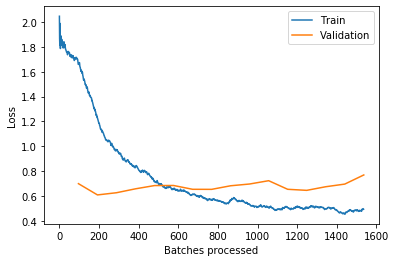

18_448_lr_0.001_cyc_16_ps_0.85


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.880535,0.797518,0.355856,0.644144,00:44
1,1.456168,0.607875,0.198198,0.801802,00:43
2,1.111146,0.648420,0.220721,0.779279,00:43
3,0.906608,0.700706,0.211712,0.788288,00:44
4,0.782005,0.708381,0.207207,0.792793,00:43
5,0.687366,0.767099,0.229730,0.770270,00:44
6,0.635065,0.724521,0.193694,0.806306,00:43
7,0.606095,0.703785,0.207207,0.792793,00:44
8,0.565653,0.767087,0.216216,0.783784,00:44
9,0.547001,0.855371,0.252252,0.747748,00:43


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 6 with accuracy value: 0.8063063025474548.


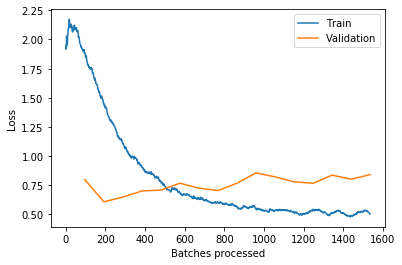

18_448_lr_0.001_cyc_16_ps_0.9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.261993,0.991915,0.513514,0.486486,00:43
1,1.838398,0.708822,0.283784,0.716216,00:44
2,1.396414,0.644614,0.225225,0.774775,00:43
3,1.032208,0.660910,0.220721,0.779279,00:43
4,0.878127,0.712176,0.229730,0.770270,00:43
5,0.733637,0.726099,0.216216,0.783784,00:44
6,0.673763,0.698594,0.202703,0.797297,00:43
7,0.638495,0.712276,0.211712,0.788288,00:44
8,0.605595,0.793444,0.220721,0.779279,00:43
9,0.601826,0.796135,0.220721,0.779279,00:44


Better model found at epoch 0 with accuracy value: 0.4864864945411682.
Better model found at epoch 1 with accuracy value: 0.7162162065505981.
Better model found at epoch 2 with accuracy value: 0.7747747898101807.
Better model found at epoch 3 with accuracy value: 0.7792792916297913.
Better model found at epoch 5 with accuracy value: 0.7837837934494019.
Better model found at epoch 6 with accuracy value: 0.7972972989082336.


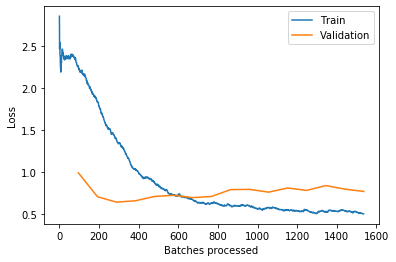

18_448_lr_0.0003_cyc_16_ps_0.5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.309667,0.914104,0.436937,0.563063,00:44
1,1.007073,0.668608,0.238739,0.761261,00:44
2,0.822564,0.635465,0.216216,0.783784,00:43
3,0.722750,0.593035,0.193694,0.806306,00:43
4,0.697701,0.603769,0.193694,0.806306,00:44
5,0.673186,0.619446,0.189189,0.810811,00:44
6,0.618413,0.643653,0.211712,0.788288,00:44
7,0.601721,0.586266,0.171171,0.828829,00:44
8,0.545477,0.672286,0.180180,0.819820,00:43
9,0.561820,0.656663,0.166667,0.833333,00:44


Better model found at epoch 0 with accuracy value: 0.5630630850791931.
Better model found at epoch 1 with accuracy value: 0.7612612843513489.
Better model found at epoch 2 with accuracy value: 0.7837837934494019.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.
Better model found at epoch 5 with accuracy value: 0.8108108043670654.
Better model found at epoch 7 with accuracy value: 0.8288288116455078.
Better model found at epoch 9 with accuracy value: 0.8333333134651184.
Better model found at epoch 11 with accuracy value: 0.8423423171043396.
Better model found at epoch 14 with accuracy value: 0.8468467593193054.


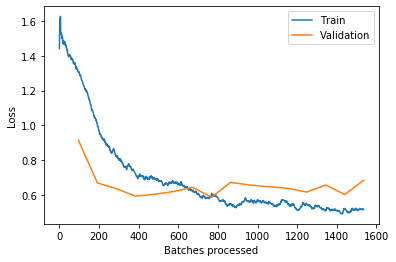

18_448_lr_0.0003_cyc_16_ps_0.8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.675034,1.152759,0.630631,0.369369,00:43
1,1.514112,0.831578,0.418919,0.581081,00:44
2,1.236245,0.653144,0.234234,0.765766,00:43
3,1.022400,0.584901,0.193694,0.806306,00:43
4,0.910825,0.600707,0.193694,0.806306,00:44
5,0.845745,0.593340,0.180180,0.819820,00:43
6,0.769313,0.589741,0.175676,0.824324,00:43
7,0.721020,0.539463,0.157658,0.842342,00:43
8,0.709677,0.543885,0.162162,0.837838,00:43
9,0.695105,0.570158,0.162162,0.837838,00:44


Better model found at epoch 0 with accuracy value: 0.36936935782432556.
Better model found at epoch 1 with accuracy value: 0.5810810923576355.
Better model found at epoch 2 with accuracy value: 0.7657657861709595.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.
Better model found at epoch 5 with accuracy value: 0.8198198080062866.
Better model found at epoch 6 with accuracy value: 0.8243243098258972.
Better model found at epoch 7 with accuracy value: 0.8423423171043396.


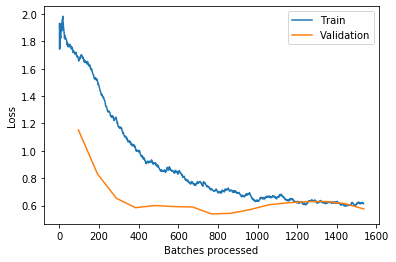

18_448_lr_0.0003_cyc_16_ps_0.85


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.026505,1.018752,0.554054,0.445946,00:43
1,1.691406,0.764868,0.324324,0.675676,00:44
2,1.442004,0.643630,0.229730,0.770270,00:43
3,1.187199,0.656897,0.234234,0.765766,00:43
4,1.028492,0.617361,0.184685,0.815315,00:44
5,0.939984,0.629874,0.198198,0.801802,00:43
6,0.835447,0.644029,0.202703,0.797297,00:44
7,0.816182,0.631176,0.175676,0.824324,00:43
8,0.760837,0.663028,0.202703,0.797297,00:44
9,0.725790,0.652808,0.193694,0.806306,00:43


Better model found at epoch 0 with accuracy value: 0.44594594836235046.
Better model found at epoch 1 with accuracy value: 0.6756756901741028.
Better model found at epoch 2 with accuracy value: 0.7702702879905701.
Better model found at epoch 4 with accuracy value: 0.815315306186676.
Better model found at epoch 7 with accuracy value: 0.8243243098258972.
Better model found at epoch 11 with accuracy value: 0.8288288116455078.


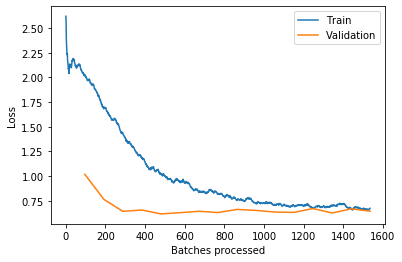

18_448_lr_0.0003_cyc_16_ps_0.9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.265114,0.998140,0.513514,0.486486,00:44
1,2.075521,0.769920,0.337838,0.662162,00:44
2,1.765513,0.667666,0.252252,0.747748,00:44
3,1.409585,0.657261,0.198198,0.801802,00:44
4,1.213620,0.631974,0.198198,0.801802,00:43
5,1.118470,0.617223,0.207207,0.792793,00:44
6,1.001480,0.615429,0.207207,0.792793,00:44
7,0.902888,0.657992,0.193694,0.806306,00:43
8,0.860310,0.654610,0.189189,0.810811,00:44
9,0.808442,0.634920,0.166667,0.833333,00:44


Better model found at epoch 0 with accuracy value: 0.4864864945411682.
Better model found at epoch 1 with accuracy value: 0.662162184715271.
Better model found at epoch 2 with accuracy value: 0.7477477192878723.
Better model found at epoch 3 with accuracy value: 0.8018018007278442.
Better model found at epoch 7 with accuracy value: 0.8063063025474548.
Better model found at epoch 8 with accuracy value: 0.8108108043670654.
Better model found at epoch 9 with accuracy value: 0.8333333134651184.


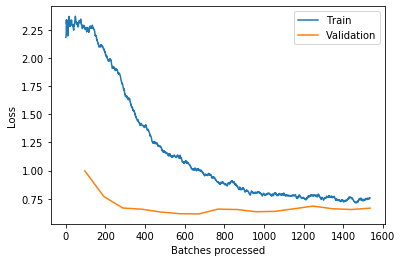

18_448_lr_0.0001_cyc_16_ps_0.5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.321987,1.138855,0.603604,0.396396,00:43
1,1.186544,0.887967,0.450450,0.549550,00:43
2,1.003317,0.780775,0.333333,0.666667,00:43
3,0.876169,0.708597,0.270270,0.729730,00:43
4,0.792239,0.665934,0.243243,0.756757,00:44
5,0.761181,0.660308,0.225225,0.774775,00:43
6,0.714526,0.613840,0.193694,0.806306,00:44
7,0.687437,0.630375,0.189189,0.810811,00:44
8,0.680577,0.640938,0.184685,0.815315,00:43
9,0.684775,0.606610,0.180180,0.819820,00:43


Better model found at epoch 0 with accuracy value: 0.3963963985443115.
Better model found at epoch 1 with accuracy value: 0.5495495200157166.
Better model found at epoch 2 with accuracy value: 0.6666666865348816.
Better model found at epoch 3 with accuracy value: 0.7297297120094299.
Better model found at epoch 4 with accuracy value: 0.7567567825317383.
Better model found at epoch 5 with accuracy value: 0.7747747898101807.
Better model found at epoch 6 with accuracy value: 0.8063063025474548.
Better model found at epoch 7 with accuracy value: 0.8108108043670654.
Better model found at epoch 8 with accuracy value: 0.815315306186676.
Better model found at epoch 9 with accuracy value: 0.8198198080062866.
Better model found at epoch 11 with accuracy value: 0.8288288116455078.


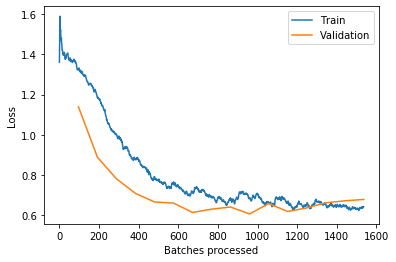

18_448_lr_0.0001_cyc_16_ps_0.8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.997360,1.256435,0.675676,0.324324,00:44
1,1.848401,1.035287,0.513514,0.486486,00:44
2,1.571279,0.851018,0.391892,0.608108,00:44
3,1.358542,0.778480,0.328829,0.671171,00:44
4,1.194700,0.698603,0.247748,0.752252,00:44
5,1.087656,0.708161,0.252252,0.747748,00:43
6,1.035943,0.690924,0.247748,0.752252,00:44
7,0.989510,0.694250,0.243243,0.756757,00:43
8,1.011629,0.697843,0.220721,0.779279,00:43
9,0.933930,0.708796,0.225225,0.774775,00:44


Better model found at epoch 0 with accuracy value: 0.3243243098258972.
Better model found at epoch 1 with accuracy value: 0.4864864945411682.
Better model found at epoch 2 with accuracy value: 0.6081081032752991.
Better model found at epoch 3 with accuracy value: 0.6711711883544922.
Better model found at epoch 4 with accuracy value: 0.7522522807121277.
Better model found at epoch 7 with accuracy value: 0.7567567825317383.
Better model found at epoch 8 with accuracy value: 0.7792792916297913.
Better model found at epoch 12 with accuracy value: 0.7837837934494019.


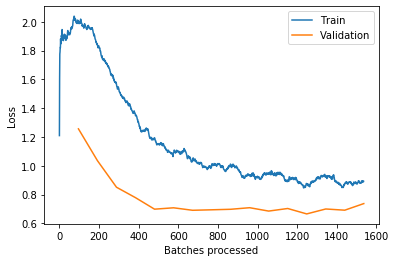

18_448_lr_0.0001_cyc_16_ps_0.85


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.063704,1.163499,0.635135,0.364865,00:44
1,1.990432,0.953460,0.445946,0.554054,00:43
2,1.735413,0.786013,0.333333,0.666667,00:43
3,1.503541,0.686812,0.247748,0.752252,00:44
4,1.346056,0.661550,0.234234,0.765766,00:43
5,1.203999,0.642154,0.225225,0.774775,00:43
6,1.124969,0.623094,0.216216,0.783784,00:44
7,1.054646,0.662569,0.225225,0.774775,00:43
8,1.040043,0.637697,0.216216,0.783784,00:43
9,1.034207,0.641319,0.216216,0.783784,00:43


Better model found at epoch 0 with accuracy value: 0.36486485600471497.
Better model found at epoch 1 with accuracy value: 0.5540540814399719.
Better model found at epoch 2 with accuracy value: 0.6666666865348816.
Better model found at epoch 3 with accuracy value: 0.7522522807121277.
Better model found at epoch 4 with accuracy value: 0.7657657861709595.
Better model found at epoch 5 with accuracy value: 0.7747747898101807.
Better model found at epoch 6 with accuracy value: 0.7837837934494019.
Better model found at epoch 10 with accuracy value: 0.7882882952690125.


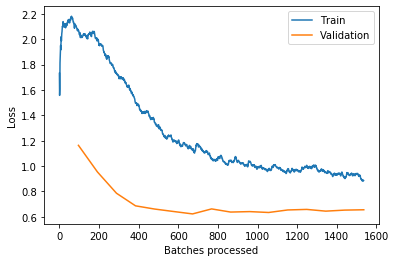

18_448_lr_0.0001_cyc_16_ps_0.9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.265797,1.014678,0.518018,0.481982,00:43
1,2.217680,0.910497,0.405405,0.594595,00:44
2,2.049371,0.799027,0.315315,0.684685,00:43
3,1.718302,0.743332,0.261261,0.738739,00:44
4,1.627390,0.714058,0.234234,0.765766,00:43
5,1.460481,0.689833,0.229730,0.770270,00:44
6,1.377965,0.708456,0.229730,0.770270,00:43
7,1.289178,0.686831,0.220721,0.779279,00:44
8,1.223546,0.661078,0.216216,0.783784,00:44
9,1.190488,0.674092,0.216216,0.783784,00:44


Better model found at epoch 0 with accuracy value: 0.4819819927215576.
Better model found at epoch 1 with accuracy value: 0.5945945978164673.
Better model found at epoch 2 with accuracy value: 0.684684693813324.
Better model found at epoch 3 with accuracy value: 0.7387387156486511.
Better model found at epoch 4 with accuracy value: 0.7657657861709595.
Better model found at epoch 5 with accuracy value: 0.7702702879905701.
Better model found at epoch 7 with accuracy value: 0.7792792916297913.
Better model found at epoch 8 with accuracy value: 0.7837837934494019.
Better model found at epoch 10 with accuracy value: 0.7972972989082336.
Better model found at epoch 13 with accuracy value: 0.8018018007278442.


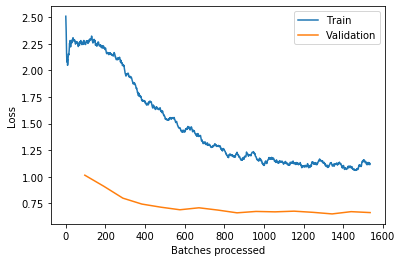

saved stats to: stats\18_448_stats.p


In [29]:
for key, params in get_params(all_cycles=[16], all_lr=[1e-3, 3e-4, 1e-4]):
    for ps in [0.5, 0.8, 0.85, 0.9]:
        do_train(key, ps=ps, **params)
all_stats.save()

In [30]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.126  med: 0.200   Loss -- best: 0.445  med: 0.672

18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.003_cyc_8  error_rate: 0.144   accuracy: 0.856   loss:0.5381
18_448_lr_0.0003_cyc_16_ps_0.5  error_rate: 0.153   accuracy: 0.847   loss:0.6021
18_448_lr_0.03_cyc_4  error_rate: 0.158   accuracy: 0.842   loss:0.5855
18_448_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.158   accuracy: 0.842   loss:0.5395
18_448_lr_0.001_cyc_8  error_rate: 0.162   accuracy: 0.838   loss:0.6341
18_448_lr_0.001_cyc_16_ps_0.5  error_rate: 0.162   accuracy: 0.838   loss:0.6643
18_448_lr_0.1_cyc_8   error_rate: 0.167   accuracy: 0.833   loss:0.6531
18_448_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.167   accuracy: 0.833   loss:0.6349
18_448_lr_0.03_cyc_2  error_rate: 0.171   accuracy: 0.829   loss:0.6928


### Focus on specific configurations

18_224cut_lr_0.01_cyc_8

18_448_lr_0.01_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.765262,0.744833,0.252252,0.747748,00:43
1,0.697561,0.662367,0.270270,0.729730,00:44
2,0.636085,2.152861,0.522523,0.477477,00:44
3,0.596449,0.744152,0.355856,0.644144,00:44
4,0.554576,0.693774,0.193694,0.806306,00:44
5,0.504692,0.754402,0.243243,0.756757,00:44
6,0.462111,0.776537,0.220721,0.779279,00:44
7,0.455705,0.587779,0.166667,0.833333,00:44


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 4 with accuracy value: 0.8063063025474548.
Better model found at epoch 7 with accuracy value: 0.8333333134651184.


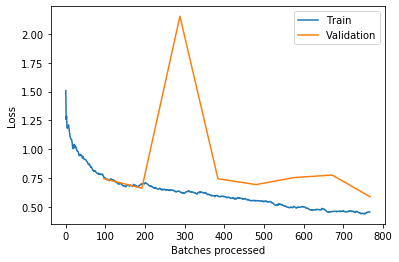

18_448_lr_0.01_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.789164,0.875491,0.319820,0.680180,00:43
1,0.669327,1.139777,0.387387,0.612613,00:43
2,0.635154,1.297382,0.418919,0.581081,00:43
3,0.608115,0.746849,0.270270,0.729730,00:43
4,0.537874,0.800608,0.238739,0.761261,00:44
5,0.504799,0.697944,0.207207,0.792793,00:44
6,0.450035,0.891880,0.247748,0.752252,00:43
7,0.446656,0.757790,0.216216,0.783784,00:43


Better model found at epoch 0 with accuracy value: 0.6801801919937134.
Better model found at epoch 3 with accuracy value: 0.7297297120094299.
Better model found at epoch 4 with accuracy value: 0.7612612843513489.
Better model found at epoch 5 with accuracy value: 0.792792797088623.


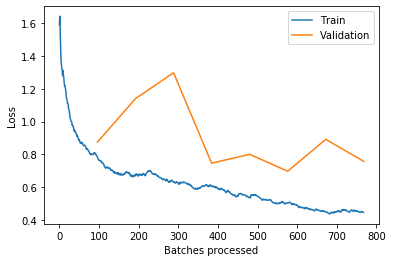

18_448_lr_0.01_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.848727,0.847005,0.351351,0.648649,00:43
1,0.683045,0.605818,0.166667,0.833333,00:43
2,0.664940,0.522095,0.126126,0.873874,00:43
3,0.590174,0.656150,0.175676,0.824324,00:43
4,0.545305,0.995043,0.328829,0.671171,00:43
5,0.508484,0.638431,0.184685,0.815315,00:44
6,0.469856,0.797092,0.220721,0.779279,00:43
7,0.437662,0.752434,0.216216,0.783784,00:44


Better model found at epoch 0 with accuracy value: 0.6486486196517944.
Better model found at epoch 1 with accuracy value: 0.8333333134651184.
Better model found at epoch 2 with accuracy value: 0.8738738894462585.


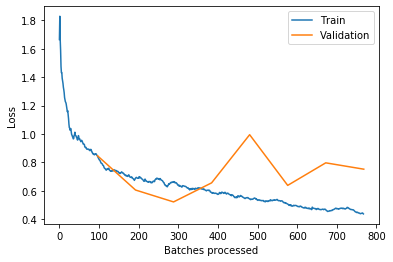

18_448_lr_0.01_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.828937,0.835379,0.292793,0.707207,00:43
1,0.663627,0.766695,0.256757,0.743243,00:43
2,0.637530,0.515388,0.130631,0.869369,00:44
3,0.607618,0.558902,0.180180,0.819820,00:44
4,0.565693,0.679276,0.229730,0.770270,00:43
5,0.526734,0.631177,0.180180,0.819820,00:44
6,0.478849,0.769828,0.247748,0.752252,00:43
7,0.453057,0.768801,0.238739,0.761261,00:44


Better model found at epoch 0 with accuracy value: 0.707207202911377.
Better model found at epoch 1 with accuracy value: 0.7432432174682617.
Better model found at epoch 2 with accuracy value: 0.869369387626648.


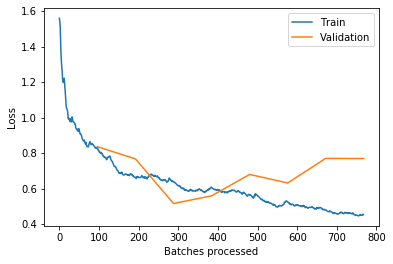

18_448_lr_0.01_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.823473,0.869515,0.265766,0.734234,00:43
1,0.715722,0.576569,0.202703,0.797297,00:44
2,0.648015,0.997537,0.328829,0.671171,00:43
3,0.593154,0.419957,0.121622,0.878378,00:44
4,0.545833,0.598525,0.252252,0.747748,00:43
5,0.525369,0.577951,0.144144,0.855856,00:44
6,0.471811,0.726497,0.198198,0.801802,00:43
7,0.446126,0.614456,0.157658,0.842342,00:44


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 1 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.8783783912658691.


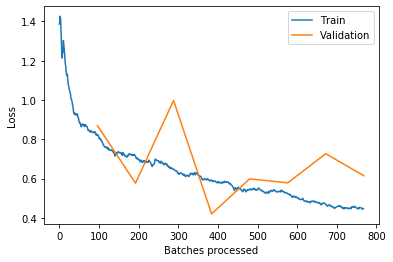

18_448_lr_0.01_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.798993,0.806502,0.256757,0.743243,00:44
1,0.698598,1.176869,0.441441,0.558559,00:43
2,0.660425,0.750250,0.279279,0.720721,00:44
3,0.599941,0.873909,0.355856,0.644144,00:43
4,0.525107,0.610121,0.175676,0.824324,00:44
5,0.504530,0.455475,0.126126,0.873874,00:44
6,0.490975,0.697552,0.220721,0.779279,00:43
7,0.449128,0.733752,0.234234,0.765766,00:44


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 4 with accuracy value: 0.8243243098258972.
Better model found at epoch 5 with accuracy value: 0.8738738894462585.


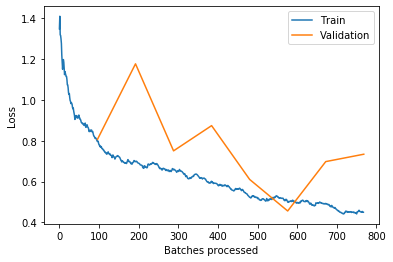

18_448_lr_0.01_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.769360,0.694144,0.216216,0.783784,00:43
1,0.679948,0.692490,0.238739,0.761261,00:43
2,0.624904,0.718210,0.238739,0.761261,00:44
3,0.582590,0.742358,0.234234,0.765766,00:44
4,0.578058,0.982096,0.337838,0.662162,00:43
5,0.500416,0.646091,0.162162,0.837838,00:44
6,0.468977,0.633170,0.180180,0.819820,00:43
7,0.438820,0.739440,0.198198,0.801802,00:44


Better model found at epoch 0 with accuracy value: 0.7837837934494019.
Better model found at epoch 5 with accuracy value: 0.837837815284729.


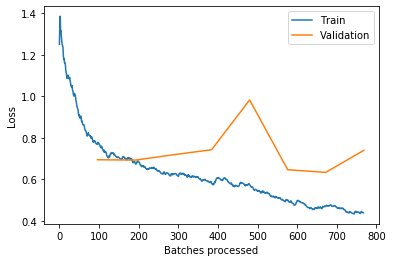

18_448_lr_0.01_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.804354,0.915465,0.297297,0.702703,00:43
1,0.670561,1.283314,0.405405,0.594595,00:43
2,0.649582,0.739614,0.256757,0.743243,00:44
3,0.612909,1.088630,0.315315,0.684685,00:43
4,0.529743,0.660514,0.193694,0.806306,00:44
5,0.511219,0.634688,0.189189,0.810811,00:43
6,0.455061,0.679392,0.202703,0.797297,00:43
7,0.434791,0.825595,0.229730,0.770270,00:43


Better model found at epoch 0 with accuracy value: 0.7027027010917664.
Better model found at epoch 2 with accuracy value: 0.7432432174682617.
Better model found at epoch 4 with accuracy value: 0.8063063025474548.
Better model found at epoch 5 with accuracy value: 0.8108108043670654.


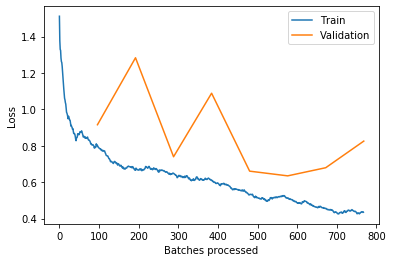

18_448_lr_0.01_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.817750,0.793128,0.265766,0.734234,00:44
1,0.690269,0.574304,0.202703,0.797297,00:44
2,0.667610,0.551764,0.198198,0.801802,00:44
3,0.596227,0.879291,0.351351,0.648649,00:43
4,0.537873,0.566602,0.153153,0.846847,00:43
5,0.511334,0.622819,0.180180,0.819820,00:44
6,0.485107,0.850470,0.229730,0.770270,00:44
7,0.445012,0.767046,0.198198,0.801802,00:44


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 1 with accuracy value: 0.7972972989082336.
Better model found at epoch 2 with accuracy value: 0.8018018007278442.
Better model found at epoch 4 with accuracy value: 0.8468468189239502.


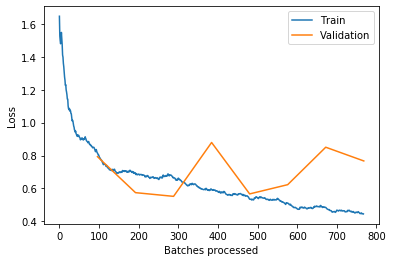

18_448_lr_0.01_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.785745,0.930139,0.301802,0.698198,00:44
1,0.690830,1.267922,0.355856,0.644144,00:43
2,0.649346,1.565404,0.382883,0.617117,00:43
3,0.609439,0.509668,0.166667,0.833333,00:43
4,0.567773,0.594383,0.189189,0.810811,00:44
5,0.512981,0.635093,0.207207,0.792793,00:44
6,0.472386,0.726117,0.216216,0.783784,00:44
7,0.449085,0.784130,0.234234,0.765766,00:44


Better model found at epoch 0 with accuracy value: 0.6981981992721558.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.


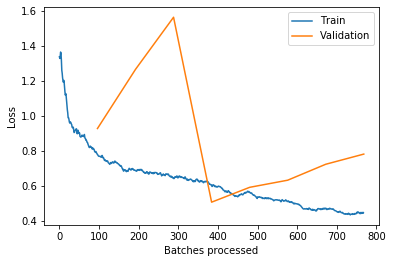

saved stats to: stats\18_448_stats.p


In [31]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [32]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.194   Loss -- best: 0.420  med: 0.652

18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_8_i3  error_rate: 0.131   accuracy: 0.869   loss:0.5154
18_448_lr_0.003_cyc_8  error_rate: 0.144   accuracy: 0.856   loss:0.5381
18_448_lr_0.01_cyc_8_i8  error_rate: 0.153   accuracy: 0.847   loss:0.5666
18_448_lr_0.0003_cyc_16_ps_0.5  error_rate: 0.153   accuracy: 0.847   loss:0.6021
18_448_lr_0.03_cyc_4  error_rate: 0.158   accuracy: 0.842   loss:0.5855
18_448_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.158   accuracy: 0.842   loss:0.5395


18_448_lr_0.01_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.797953,0.949374,0.265766,0.734234,00:43
1,0.704845,0.825669,0.297297,0.702703,00:43
2,0.600778,0.867532,0.288288,0.711712,00:43
3,0.512114,0.783850,0.256757,0.743243,00:44


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 3 with accuracy value: 0.7432432174682617.


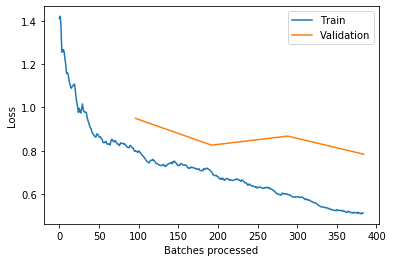

18_448_lr_0.01_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.789559,0.936892,0.346847,0.653153,00:43
1,0.663891,0.479215,0.166667,0.833333,00:44
2,0.578945,0.638151,0.256757,0.743243,00:43
3,0.501788,0.552414,0.162162,0.837838,00:43


Better model found at epoch 0 with accuracy value: 0.6531531810760498.
Better model found at epoch 1 with accuracy value: 0.8333333134651184.
Better model found at epoch 3 with accuracy value: 0.837837815284729.


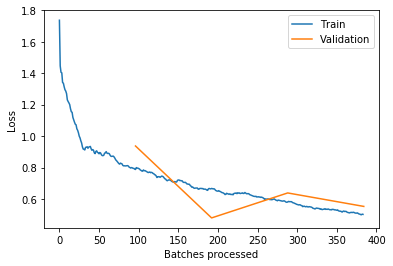

18_448_lr_0.01_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.758768,0.709419,0.229730,0.770270,00:44
1,0.669660,0.772332,0.279279,0.720721,00:43
2,0.567116,0.880511,0.252252,0.747748,00:43
3,0.497304,0.838282,0.252252,0.747748,00:44


Better model found at epoch 0 with accuracy value: 0.7702702879905701.


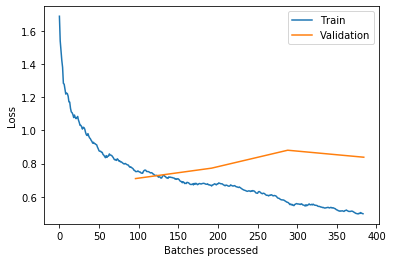

18_448_lr_0.01_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.782271,0.759338,0.229730,0.770270,00:44
1,0.683057,0.729935,0.211712,0.788288,00:44
2,0.607110,0.665615,0.229730,0.770270,00:43
3,0.541863,0.782351,0.247748,0.752252,00:44


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 1 with accuracy value: 0.7882882952690125.


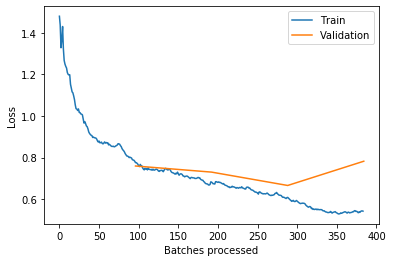

18_448_lr_0.01_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.768301,0.776606,0.247748,0.752252,00:44
1,0.688913,0.515193,0.171171,0.828829,00:43
2,0.595338,0.704952,0.207207,0.792793,00:44
3,0.501458,0.746624,0.202703,0.797297,00:44


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 1 with accuracy value: 0.8288288116455078.


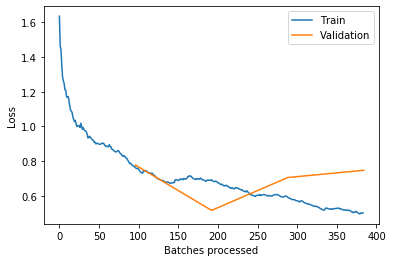

18_448_lr_0.01_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.775000,0.706894,0.252252,0.747748,00:44
1,0.675920,0.878271,0.328829,0.671171,00:43
2,0.593263,0.505620,0.153153,0.846847,00:43
3,0.508085,0.616515,0.166667,0.833333,00:44


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.8468468189239502.


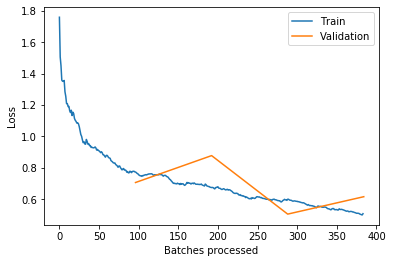

18_448_lr_0.01_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.743596,1.737771,0.581081,0.418919,00:44
1,0.686624,0.681424,0.238739,0.761261,00:44
2,0.562277,0.706474,0.234234,0.765766,00:44
3,0.514969,0.712346,0.220721,0.779279,00:43


Better model found at epoch 0 with accuracy value: 0.4189189076423645.
Better model found at epoch 1 with accuracy value: 0.7612612843513489.
Better model found at epoch 2 with accuracy value: 0.7657657861709595.
Better model found at epoch 3 with accuracy value: 0.7792792916297913.


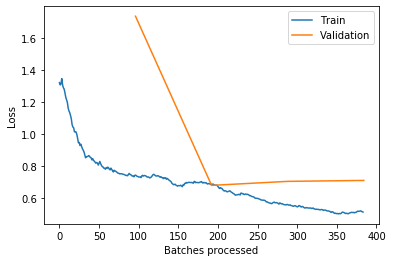

18_448_lr_0.01_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.777595,1.021860,0.364865,0.635135,00:44
1,0.699069,0.656625,0.180180,0.819820,00:43
2,0.598120,0.871525,0.315315,0.684685,00:44
3,0.527629,0.728693,0.229730,0.770270,00:44


Better model found at epoch 0 with accuracy value: 0.6351351141929626.
Better model found at epoch 1 with accuracy value: 0.8198198080062866.


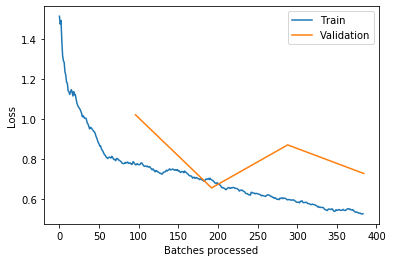

18_448_lr_0.01_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.814791,1.186705,0.427928,0.572072,00:44
1,0.673377,1.005755,0.459459,0.540541,00:43
2,0.585836,0.587590,0.180180,0.819820,00:43
3,0.507017,0.564081,0.171171,0.828829,00:43


Better model found at epoch 0 with accuracy value: 0.5720720887184143.
Better model found at epoch 2 with accuracy value: 0.8198198080062866.
Better model found at epoch 3 with accuracy value: 0.8288288116455078.


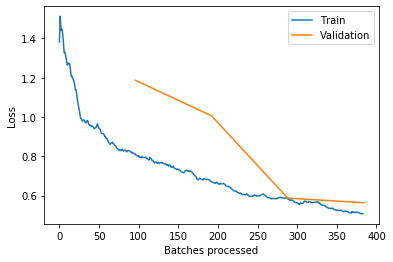

18_448_lr_0.01_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.773578,0.831350,0.355856,0.644144,00:44
1,0.679892,0.903912,0.427928,0.572072,00:44
2,0.582898,0.839895,0.256757,0.743243,00:44
3,0.501019,0.715381,0.193694,0.806306,00:43


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 2 with accuracy value: 0.7432432174682617.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.


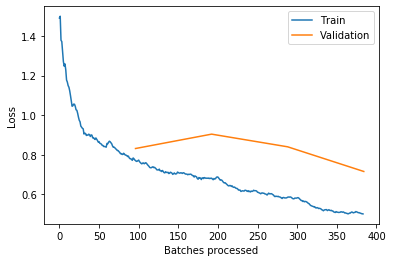

saved stats to: stats\18_448_stats.p


In [33]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [34]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.194   Loss -- best: 0.420  med: 0.654

18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_8_i3  error_rate: 0.131   accuracy: 0.869   loss:0.5154
18_448_lr_0.003_cyc_8  error_rate: 0.144   accuracy: 0.856   loss:0.5381
18_448_lr_0.01_cyc_4_i5  error_rate: 0.153   accuracy: 0.847   loss:0.5056
18_448_lr_0.01_cyc_8_i8  error_rate: 0.153   accuracy: 0.847   loss:0.5666
18_448_lr_0.0003_cyc_16_ps_0.5  error_rate: 0.153   accuracy: 0.847   loss:0.6021
18_448_lr_0.03_cyc_4  error_rate: 0.158   accuracy: 0.842   loss:0.5855


18_448_lr_0.01_cyc_12_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.784323,0.854540,0.270270,0.729730,00:44
1,0.680030,0.592927,0.229730,0.770270,00:43
2,0.623433,0.834484,0.324324,0.675676,00:44
3,0.616971,1.207999,0.472973,0.527027,00:43
4,0.591250,0.528474,0.144144,0.855856,00:43
5,0.570798,0.940733,0.274775,0.725225,00:43
6,0.543559,0.839952,0.279279,0.720721,00:44
7,0.511135,0.751144,0.202703,0.797297,00:43
8,0.471111,0.901390,0.283784,0.716216,00:44
9,0.452175,0.831053,0.256757,0.743243,00:43


Better model found at epoch 0 with accuracy value: 0.7297297120094299.
Better model found at epoch 1 with accuracy value: 0.7702702879905701.
Better model found at epoch 4 with accuracy value: 0.8558558821678162.


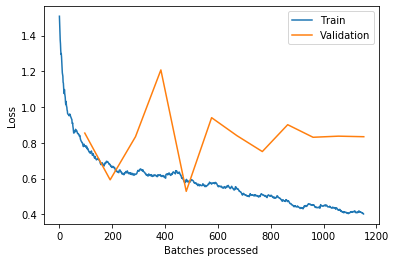

18_448_lr_0.01_cyc_12_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.791220,0.751160,0.234234,0.765766,00:43
1,0.663704,1.022855,0.328829,0.671171,00:44
2,0.664881,0.824454,0.292793,0.707207,00:44
3,0.647270,0.652021,0.229730,0.770270,00:44
4,0.610743,0.490932,0.207207,0.792793,00:43
5,0.559609,0.830689,0.292793,0.707207,00:44
6,0.531134,0.514033,0.130631,0.869369,00:43
7,0.507371,0.628636,0.189189,0.810811,00:44
8,0.453945,0.591780,0.171171,0.828829,00:44
9,0.442490,0.715061,0.202703,0.797297,00:44


Better model found at epoch 0 with accuracy value: 0.7657657861709595.
Better model found at epoch 3 with accuracy value: 0.7702702879905701.
Better model found at epoch 4 with accuracy value: 0.792792797088623.
Better model found at epoch 6 with accuracy value: 0.869369387626648.


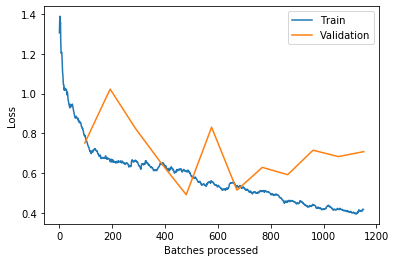

18_448_lr_0.01_cyc_12_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.772309,0.921447,0.333333,0.666667,00:44
1,0.639688,0.672932,0.193694,0.806306,00:44
2,0.639638,0.841635,0.274775,0.725225,00:44
3,0.630997,0.505291,0.153153,0.846847,00:44
4,0.591901,0.551639,0.211712,0.788288,00:43
5,0.546304,0.689633,0.283784,0.716216,00:44
6,0.519678,1.028829,0.324324,0.675676,00:43
7,0.485736,0.995314,0.274775,0.725225,00:43
8,0.459056,0.763852,0.252252,0.747748,00:44
9,0.448707,0.609535,0.198198,0.801802,00:44


Better model found at epoch 0 with accuracy value: 0.6666666269302368.
Better model found at epoch 1 with accuracy value: 0.8063063025474548.
Better model found at epoch 3 with accuracy value: 0.8468468189239502.


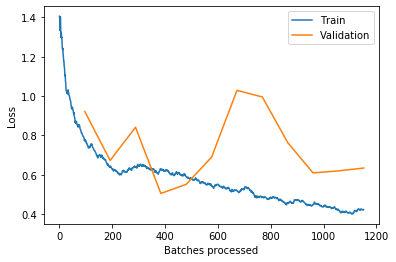

18_448_lr_0.01_cyc_12_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.809006,0.691779,0.198198,0.801802,00:43
1,0.671140,0.735458,0.234234,0.765766,00:43
2,0.670076,1.312914,0.391892,0.608108,00:43
3,0.631922,1.509153,0.454955,0.545045,00:43
4,0.583967,2.633326,0.563063,0.436937,00:44
5,0.569323,0.578450,0.184685,0.815315,00:44
6,0.531504,0.602983,0.162162,0.837838,00:43
7,0.493167,0.443165,0.121622,0.878378,00:44
8,0.489871,0.647272,0.180180,0.819820,00:43
9,0.454021,0.627181,0.175676,0.824324,00:43


Better model found at epoch 0 with accuracy value: 0.8018018007278442.
Better model found at epoch 5 with accuracy value: 0.815315306186676.
Better model found at epoch 6 with accuracy value: 0.837837815284729.
Better model found at epoch 7 with accuracy value: 0.8783783912658691.


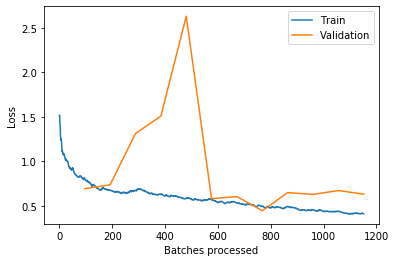

18_448_lr_0.01_cyc_12_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.779898,0.772873,0.283784,0.716216,00:43
1,0.660941,0.652883,0.238739,0.761261,00:43
2,0.639344,0.762584,0.256757,0.743243,00:44
3,0.611286,1.529801,0.481982,0.518018,00:43
4,0.592924,1.115412,0.378378,0.621622,00:44
5,0.542546,0.647131,0.229730,0.770270,00:43
6,0.529435,0.835565,0.279279,0.720721,00:43
7,0.511864,0.795517,0.234234,0.765766,00:44
8,0.462017,0.931060,0.256757,0.743243,00:44
9,0.454682,0.936505,0.279279,0.720721,00:44


Better model found at epoch 0 with accuracy value: 0.7162162065505981.
Better model found at epoch 1 with accuracy value: 0.7612612843513489.
Better model found at epoch 5 with accuracy value: 0.7702702879905701.
Better model found at epoch 10 with accuracy value: 0.7747747898101807.


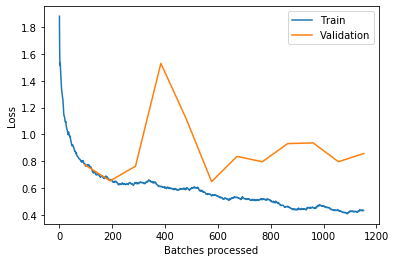

18_448_lr_0.01_cyc_12_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.796186,0.741519,0.238739,0.761261,00:43
1,0.676489,0.974307,0.355856,0.644144,00:44
2,0.647671,0.624534,0.207207,0.792793,00:43
3,0.648522,0.820060,0.288288,0.711712,00:43
4,0.593641,0.651375,0.261261,0.738739,00:43
5,0.552315,0.674789,0.256757,0.743243,00:43
6,0.513814,0.918197,0.310811,0.689189,00:43
7,0.511312,0.459727,0.139640,0.860360,00:44
8,0.482773,0.868800,0.265766,0.734234,00:43
9,0.451343,0.930641,0.256757,0.743243,00:43


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 2 with accuracy value: 0.792792797088623.
Better model found at epoch 7 with accuracy value: 0.8603603839874268.


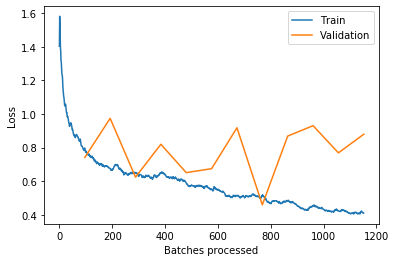

18_448_lr_0.01_cyc_12_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.760588,0.804774,0.256757,0.743243,00:44
1,0.648046,0.650988,0.184685,0.815315,00:44
2,0.646531,1.103738,0.342342,0.657658,00:43
3,0.630309,0.906761,0.346847,0.653153,00:43
4,0.586422,0.847651,0.297297,0.702703,00:44
5,0.547686,0.618359,0.189189,0.810811,00:44
6,0.544835,0.634054,0.243243,0.756757,00:43
7,0.512980,0.547599,0.171171,0.828829,00:43
8,0.485464,0.606434,0.180180,0.819820,00:44
9,0.439331,0.668900,0.184685,0.815315,00:44


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 1 with accuracy value: 0.815315306186676.
Better model found at epoch 7 with accuracy value: 0.8288288116455078.


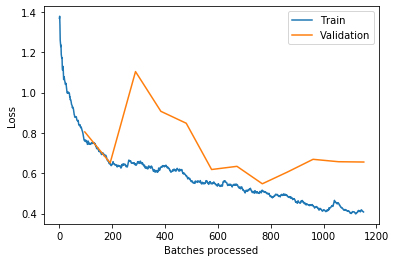

18_448_lr_0.01_cyc_12_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.749124,0.748047,0.243243,0.756757,00:43
1,0.653957,0.577519,0.171171,0.828829,00:43
2,0.619135,1.210335,0.315315,0.684685,00:43
3,0.612521,0.961303,0.337838,0.662162,00:43
4,0.555242,1.128927,0.351351,0.648649,00:44
5,0.553131,0.518769,0.189189,0.810811,00:43
6,0.526082,0.850142,0.292793,0.707207,00:43
7,0.505901,0.657622,0.207207,0.792793,00:44
8,0.472771,0.775467,0.247748,0.752252,00:43
9,0.436408,0.593998,0.180180,0.819820,00:43


Better model found at epoch 0 with accuracy value: 0.7567567825317383.
Better model found at epoch 1 with accuracy value: 0.8288288116455078.


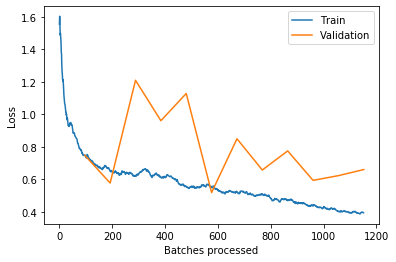

18_448_lr_0.01_cyc_12_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.813986,0.637324,0.211712,0.788288,00:43
1,0.670351,1.178211,0.459459,0.540541,00:43
2,0.634831,0.554019,0.171171,0.828829,00:43
3,0.623606,1.427402,0.436937,0.563063,00:44
4,0.573544,0.866183,0.301802,0.698198,00:43
5,0.534634,1.157911,0.382883,0.617117,00:43
6,0.509646,0.474764,0.130631,0.869369,00:44
7,0.515641,0.522898,0.126126,0.873874,00:43
8,0.469340,0.464013,0.153153,0.846847,00:44
9,0.443321,0.870499,0.234234,0.765766,00:43


Better model found at epoch 0 with accuracy value: 0.7882882952690125.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.
Better model found at epoch 6 with accuracy value: 0.869369387626648.
Better model found at epoch 7 with accuracy value: 0.8738738894462585.


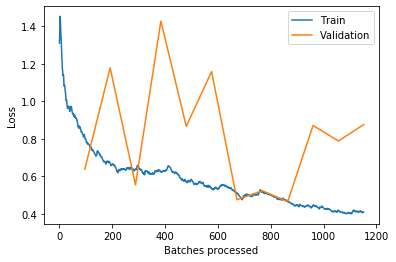

18_448_lr_0.01_cyc_12_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.791701,0.815468,0.247748,0.752252,00:43
1,0.662253,1.044941,0.301802,0.698198,00:44
2,0.665337,1.338997,0.527027,0.472973,00:44
3,0.640078,0.831625,0.315315,0.684685,00:44
4,0.594503,0.554781,0.198198,0.801802,00:43
5,0.571275,0.450827,0.148649,0.851351,00:44
6,0.526833,0.567369,0.171171,0.828829,00:44
7,0.501862,1.041082,0.283784,0.716216,00:44
8,0.474940,0.653548,0.193694,0.806306,00:44
9,0.453998,0.777789,0.225225,0.774775,00:44


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 4 with accuracy value: 0.8018018007278442.
Better model found at epoch 5 with accuracy value: 0.8513513803482056.


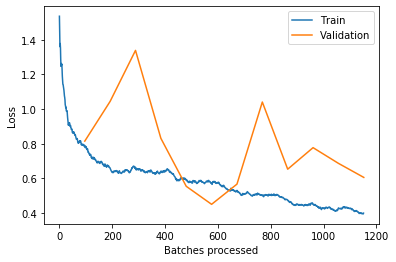

saved stats to: stats\18_448_stats.p


In [35]:
for i in range(10):
    for key, params in get_params(all_cycles=[12], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [36]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.182   Loss -- best: 0.420  med: 0.640

18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.01_cyc_12_i3  error_rate: 0.122   accuracy: 0.878   loss:0.4432
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_12_i8  error_rate: 0.126   accuracy: 0.874   loss:0.5229
18_448_lr_0.01_cyc_8_i3  error_rate: 0.131   accuracy: 0.869   loss:0.5154
18_448_lr_0.01_cyc_12_i1  error_rate: 0.131   accuracy: 0.869   loss:0.5140
18_448_lr_0.01_cyc_12_i5  error_rate: 0.140   accuracy: 0.860   loss:0.4597
18_448_lr_0.003_cyc_8  error_rate: 0.144   accuracy: 0.856   loss:0.5381


18_448_lr_0.02_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.769729,0.977343,0.391892,0.608108,00:44
1,0.740544,0.767513,0.274775,0.725225,00:44
2,0.701577,0.713623,0.364865,0.635135,00:43
3,0.615550,0.729744,0.220721,0.779279,00:43
4,0.571477,1.483340,0.423423,0.576577,00:43
5,0.529359,0.896341,0.306306,0.693694,00:44
6,0.486593,0.725121,0.234234,0.765766,00:43
7,0.456430,0.634545,0.189189,0.810811,00:43


Better model found at epoch 0 with accuracy value: 0.6081081032752991.
Better model found at epoch 1 with accuracy value: 0.7252252101898193.
Better model found at epoch 3 with accuracy value: 0.7792792916297913.
Better model found at epoch 7 with accuracy value: 0.8108108043670654.


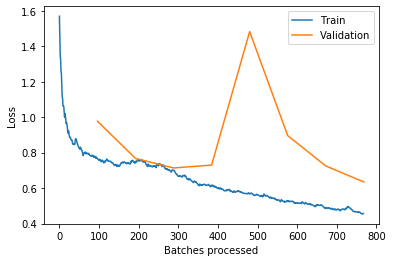

18_448_lr_0.02_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.771361,0.748217,0.252252,0.747748,00:44
1,0.735269,1.716626,0.400901,0.599099,00:43
2,0.697760,1.149560,0.342342,0.657658,00:43
3,0.601137,0.677264,0.220721,0.779279,00:44
4,0.587951,0.995614,0.342342,0.657658,00:43
5,0.532637,0.776192,0.234234,0.765766,00:44
6,0.483288,0.677124,0.162162,0.837838,00:43
7,0.449403,0.788868,0.216216,0.783784,00:43


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 3 with accuracy value: 0.7792792916297913.
Better model found at epoch 6 with accuracy value: 0.837837815284729.


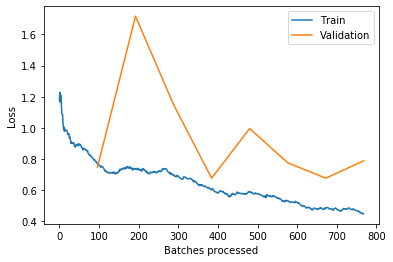

18_448_lr_0.02_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.741317,0.830715,0.274775,0.725225,00:44
1,0.766318,1.456703,0.459459,0.540541,00:43
2,0.702364,0.711701,0.189189,0.810811,00:43
3,0.636162,0.887169,0.283784,0.716216,00:44
4,0.587468,1.171373,0.545045,0.454955,00:43
5,0.522294,0.591345,0.162162,0.837838,00:43
6,0.464663,0.693664,0.207207,0.792793,00:43
7,0.457359,0.666095,0.198198,0.801802,00:43


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 2 with accuracy value: 0.8108108043670654.
Better model found at epoch 5 with accuracy value: 0.837837815284729.


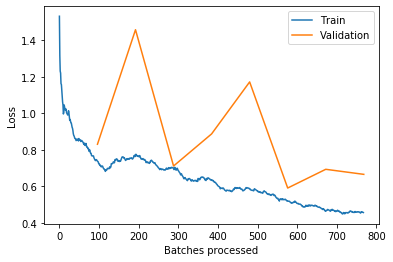

18_448_lr_0.02_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.743118,0.806893,0.256757,0.743243,00:43
1,0.758228,0.668009,0.324324,0.675676,00:43
2,0.696145,1.083172,0.400901,0.599099,00:43
3,0.603327,0.707055,0.234234,0.765766,00:43
4,0.578440,0.931261,0.369369,0.630631,00:44
5,0.519006,0.829231,0.297297,0.702703,00:44
6,0.481164,0.876603,0.256757,0.743243,00:43
7,0.461852,0.709601,0.225225,0.774775,00:44


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 3 with accuracy value: 0.7657657861709595.
Better model found at epoch 7 with accuracy value: 0.7747747898101807.


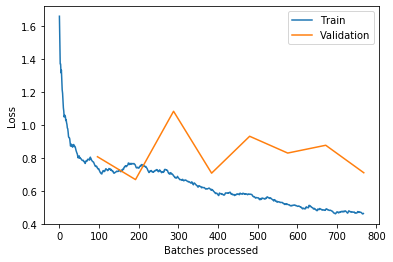

18_448_lr_0.02_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.773269,0.663480,0.292793,0.707207,00:43
1,0.788439,0.690050,0.265766,0.734234,00:43
2,0.691701,0.679430,0.364865,0.635135,00:44
3,0.625646,1.196438,0.531532,0.468468,00:43
4,0.578933,0.737498,0.391892,0.608108,00:43
5,0.525424,0.916286,0.400901,0.599099,00:43
6,0.500520,0.997280,0.328829,0.671171,00:43
7,0.449376,0.828929,0.220721,0.779279,00:43


Better model found at epoch 0 with accuracy value: 0.707207202911377.
Better model found at epoch 1 with accuracy value: 0.7342342138290405.
Better model found at epoch 7 with accuracy value: 0.7792792916297913.


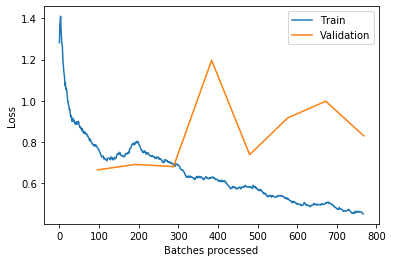

18_448_lr_0.02_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.745806,1.002356,0.364865,0.635135,00:43
1,0.753060,1.596130,0.540541,0.459459,00:43
2,0.659596,0.531533,0.175676,0.824324,00:43
3,0.637572,0.545933,0.162162,0.837838,00:44
4,0.559168,0.649757,0.162162,0.837838,00:44
5,0.518855,0.683589,0.198198,0.801802,00:43
6,0.496633,0.671044,0.202703,0.797297,00:43
7,0.445383,0.682870,0.189189,0.810811,00:44


Better model found at epoch 0 with accuracy value: 0.6351351141929626.
Better model found at epoch 2 with accuracy value: 0.8243243098258972.
Better model found at epoch 3 with accuracy value: 0.837837815284729.


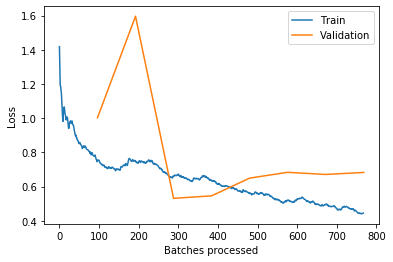

18_448_lr_0.02_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.739384,0.593219,0.265766,0.734234,00:43
1,0.722667,1.598372,0.621622,0.378378,00:44
2,0.687940,0.581610,0.162162,0.837838,00:44
3,0.603859,0.734001,0.207207,0.792793,00:43
4,0.566164,0.578758,0.126126,0.873874,00:44
5,0.535393,0.545741,0.175676,0.824324,00:43
6,0.465101,0.585487,0.157658,0.842342,00:43
7,0.458608,0.554122,0.162162,0.837838,00:43


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 2 with accuracy value: 0.837837815284729.
Better model found at epoch 4 with accuracy value: 0.8738738894462585.


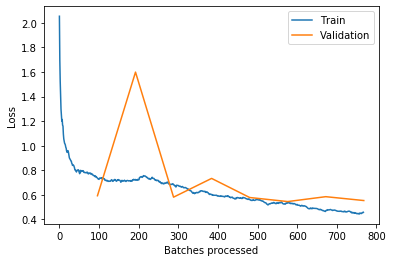

18_448_lr_0.02_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.749566,0.778391,0.238739,0.761261,00:44
1,0.712727,1.102642,0.360360,0.639640,00:43
2,0.689408,0.702817,0.342342,0.657658,00:44
3,0.619497,1.042344,0.346847,0.653153,00:44
4,0.581066,0.542124,0.144144,0.855856,00:43
5,0.521010,0.469713,0.112613,0.887387,00:44
6,0.464890,0.768704,0.220721,0.779279,00:44
7,0.450245,0.711384,0.189189,0.810811,00:44


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 4 with accuracy value: 0.8558558821678162.
Better model found at epoch 5 with accuracy value: 0.8873873949050903.


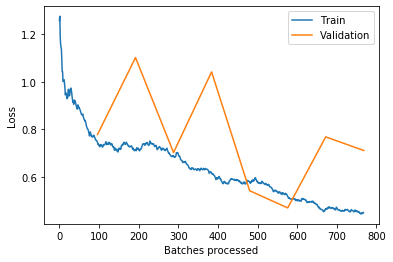

18_448_lr_0.02_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.766268,0.844412,0.364865,0.635135,00:44
1,0.751089,0.778694,0.360360,0.639640,00:44
2,0.704825,0.592315,0.234234,0.765766,00:43
3,0.636666,0.800170,0.274775,0.725225,00:43
4,0.566165,0.557775,0.175676,0.824324,00:44
5,0.527079,1.155446,0.378378,0.621622,00:43
6,0.483004,0.617063,0.202703,0.797297,00:44
7,0.471576,0.646424,0.198198,0.801802,00:43


Better model found at epoch 0 with accuracy value: 0.6351351141929626.
Better model found at epoch 1 with accuracy value: 0.6396396160125732.
Better model found at epoch 2 with accuracy value: 0.7657657861709595.
Better model found at epoch 4 with accuracy value: 0.8243243098258972.


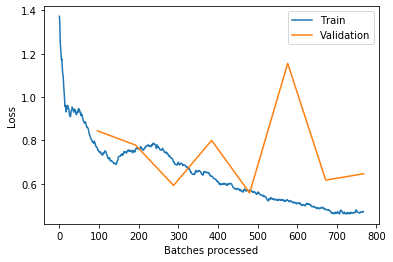

18_448_lr_0.02_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.760449,1.149644,0.409910,0.590090,00:44
1,0.778609,0.989578,0.459459,0.540541,00:43
2,0.675171,0.567969,0.171171,0.828829,00:43
3,0.634906,0.844972,0.378378,0.621622,00:44
4,0.556849,0.863978,0.279279,0.720721,00:43
5,0.535941,0.830811,0.274775,0.725225,00:44
6,0.498270,0.831244,0.256757,0.743243,00:43
7,0.478130,0.829611,0.247748,0.752252,00:44


Better model found at epoch 0 with accuracy value: 0.5900900959968567.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.


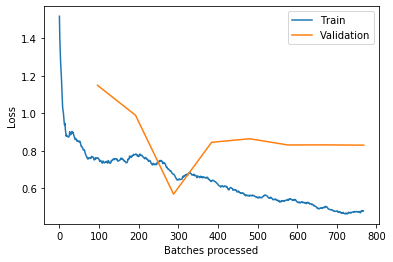

saved stats to: stats\18_448_stats.p


In [37]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [38]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.113  med: 0.173   Loss -- best: 0.420  med: 0.635

18_448_lr_0.02_cyc_8_i7  error_rate: 0.113   accuracy: 0.887   loss:0.4697
18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.01_cyc_12_i3  error_rate: 0.122   accuracy: 0.878   loss:0.4432
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_12_i8  error_rate: 0.126   accuracy: 0.874   loss:0.5229
18_448_lr_0.02_cyc_8_i6  error_rate: 0.126   accuracy: 0.874   loss:0.5788
18_448_lr_0.01_cyc_8_i3  error_rate: 0.131   accuracy: 0.869   loss:0.5154
18_448_lr_0.01_cyc_12_i1  error_rate: 0.131   accuracy: 0.869   loss:0.5140


18_448_lr_0.02_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.829066,2.486512,0.612613,0.387387,00:43
1,0.756003,0.673328,0.216216,0.783784,00:43
2,0.597625,0.924863,0.396396,0.603604,00:44
3,0.511536,0.772911,0.220721,0.779279,00:44


Better model found at epoch 0 with accuracy value: 0.38738739490509033.
Better model found at epoch 1 with accuracy value: 0.7837837934494019.


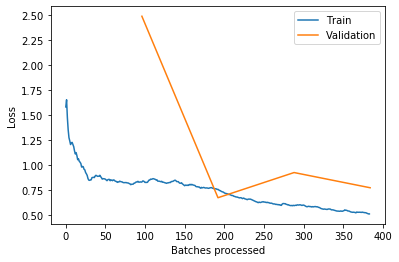

18_448_lr_0.02_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.806970,0.866539,0.324324,0.675676,00:44
1,0.777442,0.746962,0.279279,0.720721,00:44
2,0.594780,0.765102,0.193694,0.806306,00:43
3,0.517760,0.621102,0.180180,0.819820,00:43


Better model found at epoch 0 with accuracy value: 0.6756756901741028.
Better model found at epoch 1 with accuracy value: 0.7207207083702087.
Better model found at epoch 2 with accuracy value: 0.8063062429428101.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.


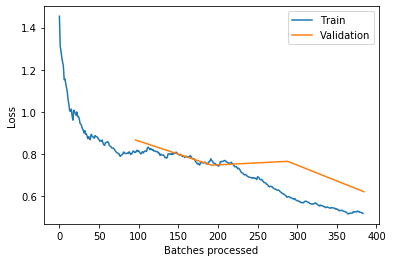

18_448_lr_0.02_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.825939,1.744886,0.346847,0.653153,00:44
1,0.753760,0.961514,0.373874,0.626126,00:44
2,0.609586,1.169407,0.373874,0.626126,00:43
3,0.532102,0.810340,0.243243,0.756757,00:44


Better model found at epoch 0 with accuracy value: 0.6531531810760498.
Better model found at epoch 3 with accuracy value: 0.7567567825317383.


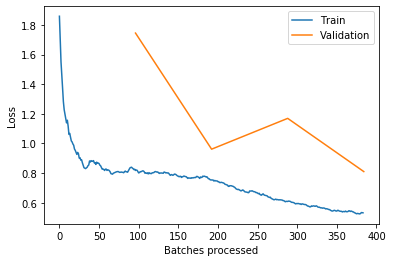

18_448_lr_0.02_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.791816,0.710375,0.342342,0.657658,00:43
1,0.756561,0.600474,0.243243,0.756757,00:43
2,0.607338,0.802892,0.301802,0.698198,00:44
3,0.519041,0.710400,0.207207,0.792793,00:43


Better model found at epoch 0 with accuracy value: 0.6576576828956604.
Better model found at epoch 1 with accuracy value: 0.7567567825317383.
Better model found at epoch 3 with accuracy value: 0.792792797088623.


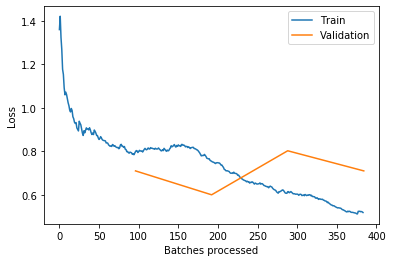

18_448_lr_0.02_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.816286,1.510398,0.400901,0.599099,00:44
1,0.744225,0.510827,0.175676,0.824324,00:44
2,0.641065,0.840772,0.297297,0.702703,00:44
3,0.532755,0.821582,0.288288,0.711712,00:44


Better model found at epoch 0 with accuracy value: 0.5990990996360779.
Better model found at epoch 1 with accuracy value: 0.8243243098258972.


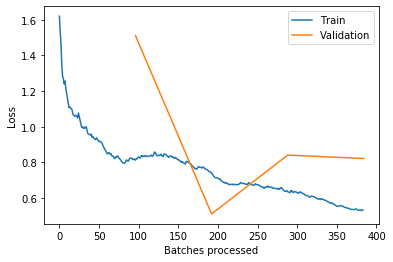

18_448_lr_0.02_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.800779,2.009910,0.612613,0.387387,00:44
1,0.772830,1.128547,0.450450,0.549550,00:43
2,0.622579,0.794238,0.279279,0.720721,00:43
3,0.533304,0.840321,0.234234,0.765766,00:43


Better model found at epoch 0 with accuracy value: 0.38738739490509033.
Better model found at epoch 1 with accuracy value: 0.5495495200157166.
Better model found at epoch 2 with accuracy value: 0.7207207083702087.
Better model found at epoch 3 with accuracy value: 0.7657657861709595.


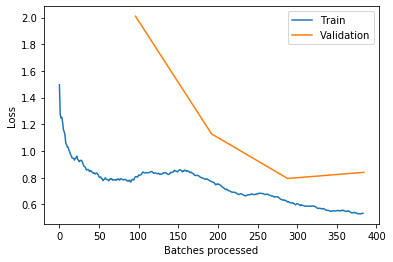

18_448_lr_0.02_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.809423,2.070133,0.612613,0.387387,00:43
1,0.748166,1.010190,0.324324,0.675676,00:44
2,0.617775,1.217056,0.364865,0.635135,00:43
3,0.523570,0.867709,0.247748,0.752252,00:44


Better model found at epoch 0 with accuracy value: 0.38738739490509033.
Better model found at epoch 1 with accuracy value: 0.6756756901741028.
Better model found at epoch 3 with accuracy value: 0.7522522807121277.


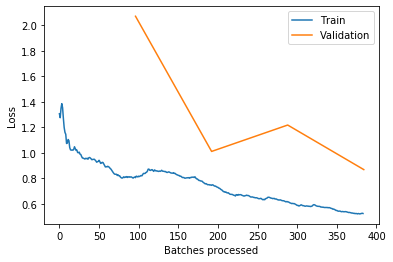

18_448_lr_0.02_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.826991,0.880151,0.238739,0.761261,00:43
1,0.768520,0.515200,0.157658,0.842342,00:43
2,0.620212,1.039021,0.346847,0.653153,00:43
3,0.530296,1.050869,0.351351,0.648649,00:44


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 1 with accuracy value: 0.8423423171043396.


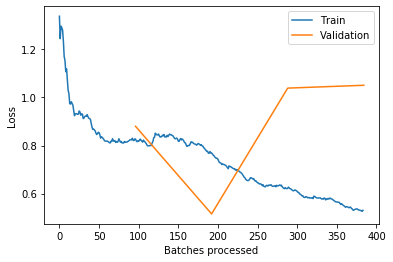

18_448_lr_0.02_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.774380,1.895963,0.617117,0.382883,00:44
1,0.741984,0.610052,0.193694,0.806306,00:44
2,0.595726,0.825445,0.229730,0.770270,00:44
3,0.523400,0.644531,0.180180,0.819820,00:44


Better model found at epoch 0 with accuracy value: 0.38288289308547974.
Better model found at epoch 1 with accuracy value: 0.8063063025474548.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.


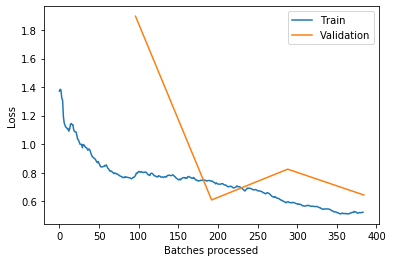

18_448_lr_0.02_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.823249,0.781220,0.351351,0.648649,00:43
1,0.713154,2.159060,0.536036,0.463964,00:44
2,0.611107,0.666309,0.207207,0.792793,00:44
3,0.513004,0.692092,0.216216,0.783784,00:43


Better model found at epoch 0 with accuracy value: 0.6486486196517944.
Better model found at epoch 2 with accuracy value: 0.792792797088623.


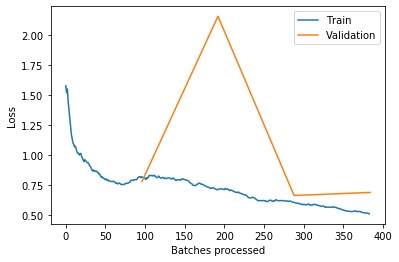

saved stats to: stats\18_448_stats.p


In [39]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [40]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.113  med: 0.180   Loss -- best: 0.420  med: 0.640

18_448_lr_0.02_cyc_8_i7  error_rate: 0.113   accuracy: 0.887   loss:0.4697
18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.01_cyc_12_i3  error_rate: 0.122   accuracy: 0.878   loss:0.4432
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_12_i8  error_rate: 0.126   accuracy: 0.874   loss:0.5229
18_448_lr_0.02_cyc_8_i6  error_rate: 0.126   accuracy: 0.874   loss:0.5788
18_448_lr_0.01_cyc_8_i3  error_rate: 0.131   accuracy: 0.869   loss:0.5154
18_448_lr_0.01_cyc_12_i1  error_rate: 0.131   accuracy: 0.869   loss:0.5140


18_448_lr_0.03_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.769211,0.649594,0.252252,0.747748,00:44
1,0.815226,0.727239,0.310811,0.689189,00:43
2,0.730289,0.613209,0.184685,0.815315,00:43
3,0.633392,0.573469,0.211712,0.788288,00:44
4,0.597228,0.537657,0.157658,0.842342,00:43
5,0.552012,0.747563,0.220721,0.779279,00:43
6,0.513286,0.699747,0.225225,0.774775,00:44
7,0.485233,0.601643,0.184685,0.815315,00:43


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.815315306186676.
Better model found at epoch 4 with accuracy value: 0.8423423171043396.


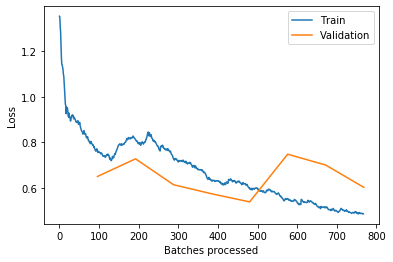

18_448_lr_0.03_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.774570,0.765574,0.319820,0.680180,00:43
1,0.828708,0.823237,0.243243,0.756757,00:43
2,0.739836,0.615055,0.211712,0.788288,00:44
3,0.670739,1.613002,0.522523,0.477477,00:43
4,0.583085,0.537952,0.189189,0.810811,00:43
5,0.551548,0.549224,0.175676,0.824324,00:44
6,0.521297,0.597332,0.148649,0.851351,00:43
7,0.490330,0.639308,0.189189,0.810811,00:43


Better model found at epoch 0 with accuracy value: 0.6801801919937134.
Better model found at epoch 1 with accuracy value: 0.7567567825317383.
Better model found at epoch 2 with accuracy value: 0.7882882952690125.
Better model found at epoch 4 with accuracy value: 0.8108108043670654.
Better model found at epoch 5 with accuracy value: 0.8243243098258972.
Better model found at epoch 6 with accuracy value: 0.851351261138916.


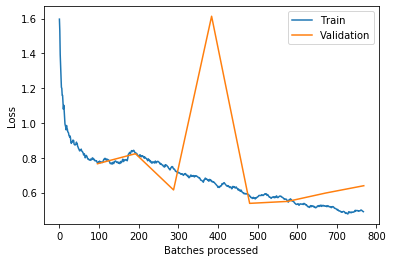

18_448_lr_0.03_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.757582,1.241411,0.355856,0.644144,00:44
1,0.833423,1.644206,0.518018,0.481982,00:44
2,0.737151,1.657419,0.423423,0.576577,00:43
3,0.641194,0.724637,0.351351,0.648649,00:44
4,0.619888,1.177346,0.342342,0.657658,00:44
5,0.559351,0.921554,0.288288,0.711712,00:44
6,0.511472,0.622302,0.193694,0.806306,00:44
7,0.483885,0.652201,0.202703,0.797297,00:43


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 3 with accuracy value: 0.6486486196517944.
Better model found at epoch 4 with accuracy value: 0.6576576828956604.
Better model found at epoch 5 with accuracy value: 0.7117117047309875.
Better model found at epoch 6 with accuracy value: 0.8063063025474548.


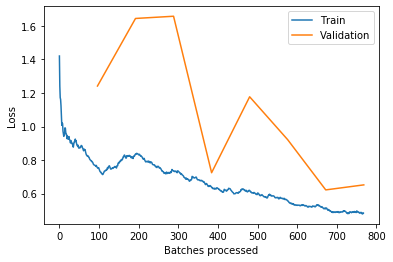

18_448_lr_0.03_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.729373,0.553708,0.171171,0.828829,00:44
1,0.800998,1.002162,0.405405,0.594595,00:43
2,0.725811,0.637809,0.229730,0.770270,00:43
3,0.656250,1.022035,0.346847,0.653153,00:44
4,0.634737,1.059906,0.509009,0.490991,00:43
5,0.567205,0.837508,0.319820,0.680180,00:44
6,0.495761,0.896833,0.283784,0.716216,00:43
7,0.473538,0.839619,0.265766,0.734234,00:44


Better model found at epoch 0 with accuracy value: 0.8288288116455078.


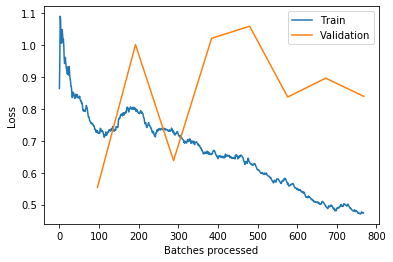

18_448_lr_0.03_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.739604,0.931251,0.328829,0.671171,00:44
1,0.829860,0.819476,0.270270,0.729730,00:43
2,0.788151,0.743391,0.261261,0.738739,00:44
3,0.681936,0.675483,0.198198,0.801802,00:44
4,0.599424,0.571150,0.162162,0.837838,00:43
5,0.551658,0.534522,0.148649,0.851351,00:44
6,0.526158,0.670386,0.220721,0.779279,00:44
7,0.492475,0.703408,0.220721,0.779279,00:43


Better model found at epoch 0 with accuracy value: 0.6711711883544922.
Better model found at epoch 1 with accuracy value: 0.7297297120094299.
Better model found at epoch 2 with accuracy value: 0.7387387156486511.
Better model found at epoch 3 with accuracy value: 0.8018018007278442.
Better model found at epoch 4 with accuracy value: 0.837837815284729.
Better model found at epoch 5 with accuracy value: 0.8513513803482056.


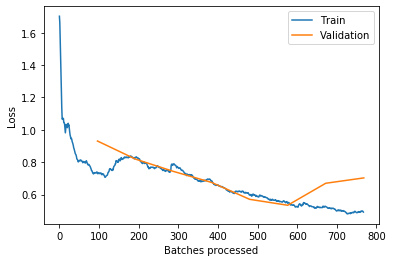

18_448_lr_0.03_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.765185,0.873325,0.283784,0.716216,00:43
1,0.783608,0.673619,0.265766,0.734234,00:44
2,0.730243,0.644006,0.256757,0.743243,00:43
3,0.665695,0.561291,0.180180,0.819820,00:43
4,0.597405,0.893930,0.315315,0.684685,00:43
5,0.563794,0.549406,0.162162,0.837838,00:44
6,0.501772,0.744652,0.229730,0.770270,00:44
7,0.460247,0.623869,0.171171,0.828829,00:44


Better model found at epoch 0 with accuracy value: 0.7162162065505981.
Better model found at epoch 1 with accuracy value: 0.7342342138290405.
Better model found at epoch 2 with accuracy value: 0.7432432174682617.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.
Better model found at epoch 5 with accuracy value: 0.837837815284729.


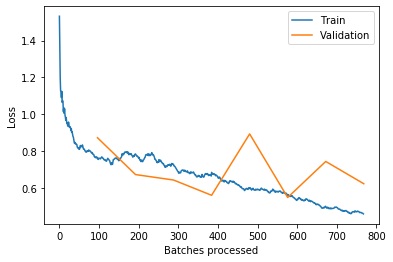

18_448_lr_0.03_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.769735,1.458040,0.436937,0.563063,00:44
1,0.807869,1.026456,0.400901,0.599099,00:43
2,0.702443,1.422781,0.590090,0.409910,00:43
3,0.655480,0.546271,0.153153,0.846847,00:44
4,0.613076,0.680508,0.175676,0.824324,00:44
5,0.548092,0.506815,0.153153,0.846847,00:44
6,0.499983,0.796980,0.229730,0.770270,00:43
7,0.487405,0.877780,0.238739,0.761261,00:44


Better model found at epoch 0 with accuracy value: 0.5630630850791931.
Better model found at epoch 1 with accuracy value: 0.5990990996360779.
Better model found at epoch 3 with accuracy value: 0.8468468189239502.


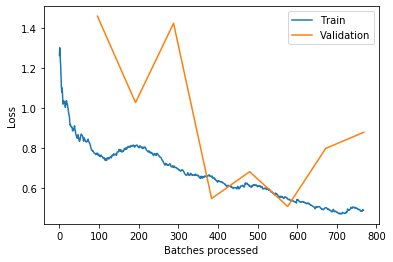

18_448_lr_0.03_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.773450,1.075900,0.400901,0.599099,00:44
1,0.837958,0.643305,0.319820,0.680180,00:44
2,0.724161,0.621373,0.202703,0.797297,00:44
3,0.657828,0.550111,0.157658,0.842342,00:43
4,0.607027,0.741702,0.247748,0.752252,00:44
5,0.550147,1.135762,0.346847,0.653153,00:43
6,0.494780,0.893907,0.297297,0.702703,00:44
7,0.478360,0.867468,0.279279,0.720721,00:43


Better model found at epoch 0 with accuracy value: 0.5990990996360779.
Better model found at epoch 1 with accuracy value: 0.6801801919937134.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.


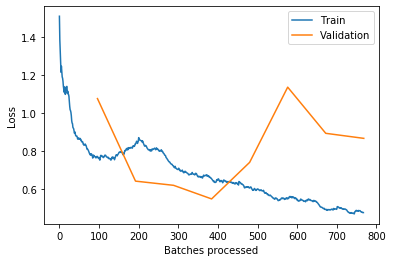

18_448_lr_0.03_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.774431,0.844724,0.333333,0.666667,00:43
1,0.835401,1.481723,0.576577,0.423423,00:44
2,0.705297,1.030520,0.400901,0.599099,00:44
3,0.692508,1.718334,0.396396,0.603604,00:43
4,0.646304,0.789272,0.274775,0.725225,00:44
5,0.571503,1.320966,0.369369,0.630631,00:44
6,0.525061,0.963133,0.297297,0.702703,00:44
7,0.505547,0.926393,0.279279,0.720721,00:43


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 4 with accuracy value: 0.7252252101898193.


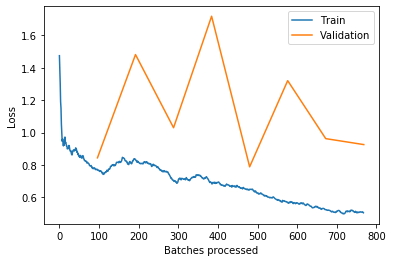

18_448_lr_0.03_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.746333,0.840943,0.373874,0.626126,00:44
1,0.820928,1.417205,0.468468,0.531532,00:44
2,0.723247,1.226753,0.450450,0.549550,00:44
3,0.678334,2.068460,0.666667,0.333333,00:44
4,0.602081,0.539734,0.216216,0.783784,00:43
5,0.558881,0.855897,0.306306,0.693694,00:44
6,0.515400,1.028424,0.342342,0.657658,00:43
7,0.482169,0.828509,0.247748,0.752252,00:44


Better model found at epoch 0 with accuracy value: 0.6261261105537415.
Better model found at epoch 4 with accuracy value: 0.7837837934494019.


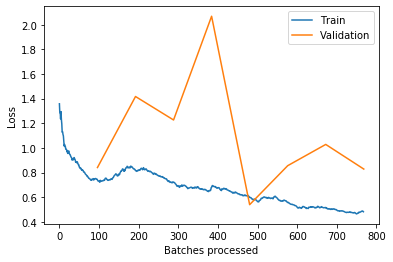

saved stats to: stats\18_448_stats.p


In [41]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [42]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.113  med: 0.178   Loss -- best: 0.420  med: 0.634

18_448_lr_0.02_cyc_8_i7  error_rate: 0.113   accuracy: 0.887   loss:0.4697
18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.01_cyc_12_i3  error_rate: 0.122   accuracy: 0.878   loss:0.4432
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_12_i8  error_rate: 0.126   accuracy: 0.874   loss:0.5229
18_448_lr_0.02_cyc_8_i6  error_rate: 0.126   accuracy: 0.874   loss:0.5788
18_448_lr_0.01_cyc_8_i3  error_rate: 0.131   accuracy: 0.869   loss:0.5154
18_448_lr_0.01_cyc_12_i1  error_rate: 0.131   accuracy: 0.869   loss:0.5140


18_448_lr_0.03_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.830832,0.851727,0.306306,0.693694,00:44
1,0.771620,0.638204,0.198198,0.801802,00:43
2,0.607624,0.686469,0.207207,0.792793,00:44
3,0.543489,0.866040,0.283784,0.716216,00:44


Better model found at epoch 0 with accuracy value: 0.6936936974525452.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.


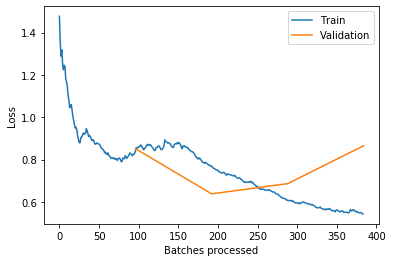

18_448_lr_0.03_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.891307,1.268641,0.504505,0.495495,00:43
1,0.879120,1.637346,0.554054,0.445946,00:44
2,0.651871,0.999247,0.315315,0.684685,00:44
3,0.544436,0.649542,0.189189,0.810811,00:43


Better model found at epoch 0 with accuracy value: 0.4954954981803894.
Better model found at epoch 2 with accuracy value: 0.684684693813324.
Better model found at epoch 3 with accuracy value: 0.8108108043670654.


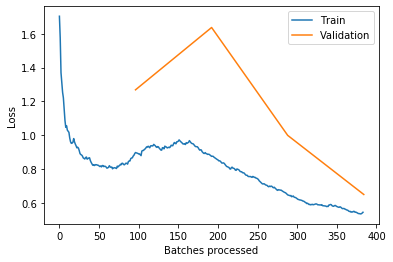

18_448_lr_0.03_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.840395,5.753427,0.662162,0.337838,00:43
1,0.812935,1.348975,0.445946,0.554054,00:43
2,0.641596,1.304494,0.369369,0.630631,00:43
3,0.540893,0.811036,0.229730,0.770270,00:43


Better model found at epoch 0 with accuracy value: 0.3378378450870514.
Better model found at epoch 1 with accuracy value: 0.5540540814399719.
Better model found at epoch 2 with accuracy value: 0.630630612373352.
Better model found at epoch 3 with accuracy value: 0.7702702879905701.


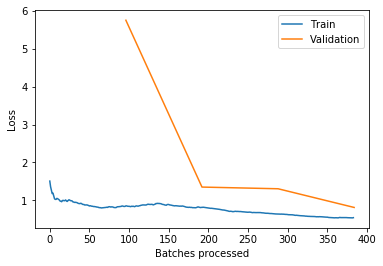

18_448_lr_0.03_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.851526,3.593303,0.666667,0.333333,00:44
1,0.798953,0.807402,0.279279,0.720721,00:44
2,0.640889,1.275028,0.405405,0.594595,00:44
3,0.547650,0.582712,0.175676,0.824324,00:43


Better model found at epoch 0 with accuracy value: 0.3333333432674408.
Better model found at epoch 1 with accuracy value: 0.7207207083702087.
Better model found at epoch 3 with accuracy value: 0.8243243098258972.


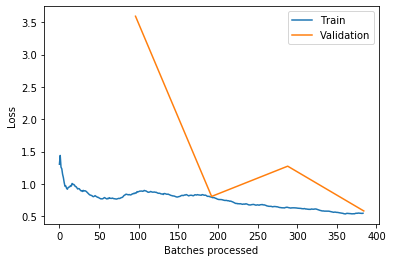

18_448_lr_0.03_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.860058,2.139094,0.608108,0.391892,00:43
1,0.801404,0.732379,0.355856,0.644144,00:43
2,0.621120,0.748939,0.193694,0.806306,00:43
3,0.522898,0.756911,0.207207,0.792793,00:43


Better model found at epoch 0 with accuracy value: 0.3918918967247009.
Better model found at epoch 1 with accuracy value: 0.6441441178321838.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.


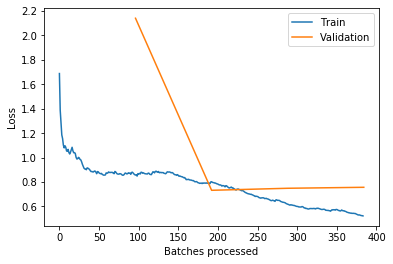

18_448_lr_0.03_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.895886,2.576306,0.644144,0.355856,00:43
1,0.821533,0.766831,0.319820,0.680180,00:43
2,0.654665,0.753758,0.238739,0.761261,00:43
3,0.556776,0.624051,0.175676,0.824324,00:44


Better model found at epoch 0 with accuracy value: 0.3558558523654938.
Better model found at epoch 1 with accuracy value: 0.6801801919937134.
Better model found at epoch 2 with accuracy value: 0.7612612843513489.
Better model found at epoch 3 with accuracy value: 0.8243243098258972.


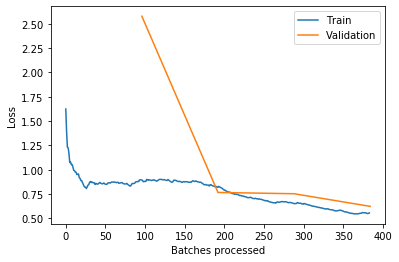

18_448_lr_0.03_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.891969,0.638495,0.225225,0.774775,00:44
1,0.792815,0.742658,0.238739,0.761261,00:44
2,0.618661,0.470080,0.139640,0.860360,00:44
3,0.545495,0.715726,0.198198,0.801802,00:44


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.8603603839874268.


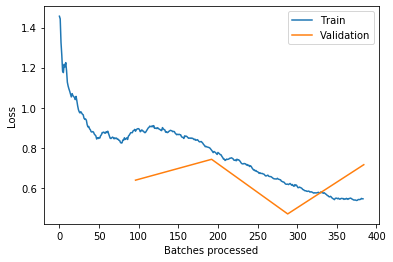

18_448_lr_0.03_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.891131,1.167878,0.572072,0.427928,00:44
1,0.766409,0.625076,0.202703,0.797297,00:43
2,0.617140,0.613537,0.202703,0.797297,00:44
3,0.503352,0.749692,0.238739,0.761261,00:44


Better model found at epoch 0 with accuracy value: 0.4279279410839081.
Better model found at epoch 1 with accuracy value: 0.7972972989082336.


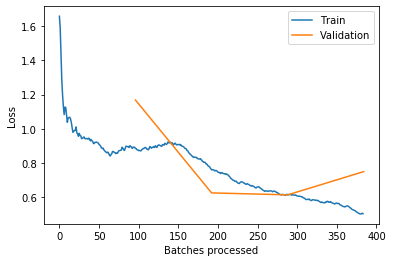

18_448_lr_0.03_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.878563,0.868753,0.418919,0.581081,00:44
1,0.792379,0.732826,0.220721,0.779279,00:44
2,0.630078,1.411360,0.382883,0.617117,00:43
3,0.538435,0.979784,0.297297,0.702703,00:43


Better model found at epoch 0 with accuracy value: 0.5810810923576355.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.


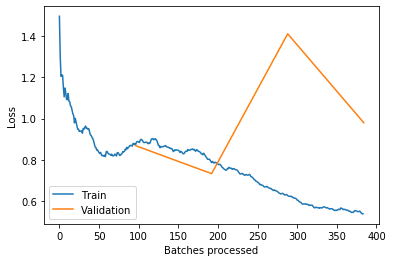

18_448_lr_0.03_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.846411,4.237679,0.662162,0.337838,00:44
1,0.766750,0.737869,0.274775,0.725225,00:44
2,0.662639,0.682471,0.207207,0.792793,00:44
3,0.560954,0.756821,0.234234,0.765766,00:43


Better model found at epoch 0 with accuracy value: 0.3378378450870514.
Better model found at epoch 1 with accuracy value: 0.7252252101898193.
Better model found at epoch 2 with accuracy value: 0.792792797088623.


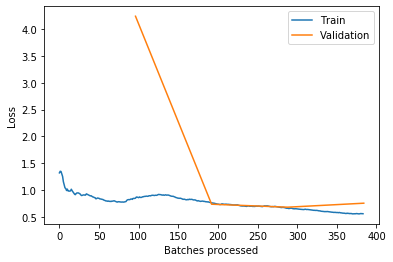

saved stats to: stats\18_448_stats.p


In [43]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [44]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.113  med: 0.180   Loss -- best: 0.420  med: 0.634

18_448_lr_0.02_cyc_8_i7  error_rate: 0.113   accuracy: 0.887   loss:0.4697
18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.01_cyc_12_i3  error_rate: 0.122   accuracy: 0.878   loss:0.4432
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_12_i8  error_rate: 0.126   accuracy: 0.874   loss:0.5229
18_448_lr_0.02_cyc_8_i6  error_rate: 0.126   accuracy: 0.874   loss:0.5788
18_448_lr_0.01_cyc_8_i3  error_rate: 0.131   accuracy: 0.869   loss:0.5154
18_448_lr_0.01_cyc_12_i1  error_rate: 0.131   accuracy: 0.869   loss:0.5140


18_448_lr_0.02_cyc_8_i0_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.956539,0.859564,0.400901,0.599099,00:44
1,0.906780,0.653575,0.288288,0.711712,00:44
2,0.833891,0.646133,0.256757,0.743243,00:43
3,0.770941,0.541902,0.130631,0.869369,00:44
4,0.750475,0.485148,0.130631,0.869369,00:44
5,0.706502,0.562308,0.180180,0.819820,00:44
6,0.694990,0.683985,0.211712,0.788288,00:44
7,0.666870,0.596529,0.171171,0.828829,00:43


Better model found at epoch 0 with accuracy value: 0.5990990996360779.
Better model found at epoch 1 with accuracy value: 0.7117117047309875.
Better model found at epoch 2 with accuracy value: 0.7432432174682617.
Better model found at epoch 3 with accuracy value: 0.869369387626648.


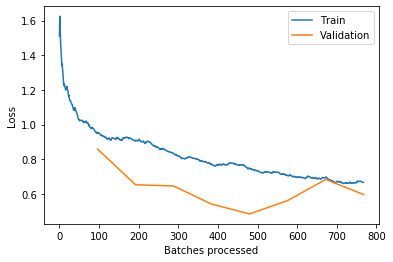

18_448_lr_0.02_cyc_8_i1_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.967953,0.766889,0.279279,0.720721,00:43
1,0.905977,0.907383,0.432432,0.567568,00:43
2,0.857334,0.575321,0.198198,0.801802,00:44
3,0.786637,1.041488,0.387387,0.612613,00:44
4,0.749869,0.863486,0.301802,0.698198,00:44
5,0.721068,0.628928,0.180180,0.819820,00:44
6,0.696444,0.620051,0.166667,0.833333,00:44
7,0.672031,0.727362,0.220721,0.779279,00:44


Better model found at epoch 0 with accuracy value: 0.7207207083702087.
Better model found at epoch 2 with accuracy value: 0.8018018007278442.
Better model found at epoch 5 with accuracy value: 0.8198198080062866.
Better model found at epoch 6 with accuracy value: 0.8333333134651184.


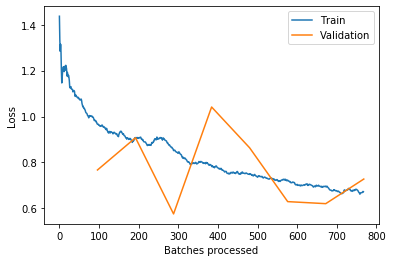

18_448_lr_0.02_cyc_8_i2_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.950362,0.860792,0.355856,0.644144,00:44
1,0.892312,0.779397,0.310811,0.689189,00:44
2,0.852639,0.584653,0.211712,0.788288,00:44
3,0.774223,0.508754,0.180180,0.819820,00:44
4,0.755825,0.626136,0.193694,0.806306,00:44
5,0.720902,0.795529,0.310811,0.689189,00:44
6,0.680428,0.578219,0.198198,0.801802,00:44
7,0.680763,0.632550,0.216216,0.783784,00:44


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 1 with accuracy value: 0.6891891956329346.
Better model found at epoch 2 with accuracy value: 0.7882882952690125.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.


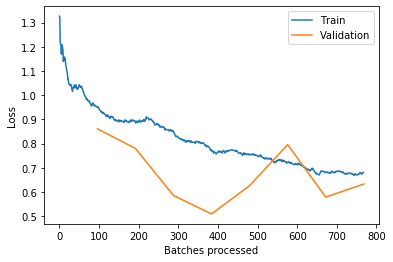

18_448_lr_0.02_cyc_8_i3_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.983470,0.961627,0.400901,0.599099,00:44
1,0.918668,1.668253,0.617117,0.382883,00:45
2,0.851539,0.701841,0.189189,0.810811,00:44
3,0.792796,0.755635,0.315315,0.684685,00:44
4,0.758301,0.556998,0.171171,0.828829,00:44
5,0.726144,0.516733,0.130631,0.869369,00:45
6,0.695867,0.614339,0.193694,0.806306,00:44
7,0.671861,0.627486,0.175676,0.824324,00:44


Better model found at epoch 0 with accuracy value: 0.5990990996360779.
Better model found at epoch 2 with accuracy value: 0.8108108043670654.
Better model found at epoch 4 with accuracy value: 0.8288288116455078.
Better model found at epoch 5 with accuracy value: 0.869369387626648.


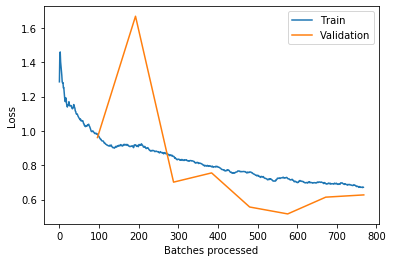

18_448_lr_0.02_cyc_8_i4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.947590,0.723863,0.337838,0.662162,00:44
1,0.919950,0.685159,0.238739,0.761261,00:44
2,0.868552,0.898039,0.387387,0.612613,00:43
3,0.782157,0.758822,0.189189,0.810811,00:43
4,0.753482,0.745121,0.315315,0.684685,00:43
5,0.735341,1.176497,0.391892,0.608108,00:44
6,0.694137,0.693495,0.216216,0.783784,00:44
7,0.665312,0.704067,0.220721,0.779279,00:44


Better model found at epoch 0 with accuracy value: 0.662162184715271.
Better model found at epoch 1 with accuracy value: 0.7612612843513489.
Better model found at epoch 3 with accuracy value: 0.8108108043670654.


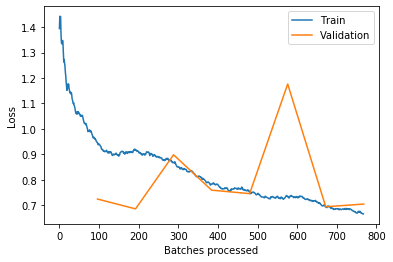

18_448_lr_0.02_cyc_8_i5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.933604,0.719743,0.252252,0.747748,00:43
1,0.893894,1.175392,0.414414,0.585586,00:44
2,0.847114,0.769892,0.310811,0.689189,00:43
3,0.801039,0.544525,0.166667,0.833333,00:43
4,0.754145,0.981463,0.360360,0.639640,00:44
5,0.715109,0.806243,0.324324,0.675676,00:43
6,0.699358,0.639343,0.193694,0.806306,00:43
7,0.676425,0.700904,0.216216,0.783784,00:43


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.


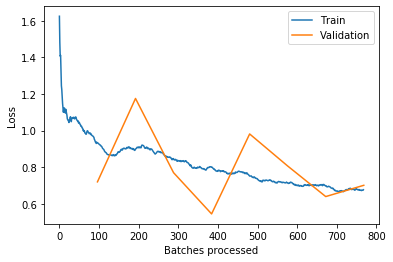

18_448_lr_0.02_cyc_8_i6_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.947204,0.652037,0.270270,0.729730,00:43
1,0.903508,1.086196,0.481982,0.518018,00:43
2,0.848687,0.637743,0.265766,0.734234,00:43
3,0.787085,0.619424,0.220721,0.779279,00:43
4,0.743641,0.599914,0.180180,0.819820,00:43
5,0.715619,0.691212,0.216216,0.783784,00:43
6,0.696307,0.555013,0.126126,0.873874,00:44
7,0.665975,0.620877,0.184685,0.815315,00:44


Better model found at epoch 0 with accuracy value: 0.7297297120094299.
Better model found at epoch 2 with accuracy value: 0.7342342138290405.
Better model found at epoch 3 with accuracy value: 0.7792792916297913.
Better model found at epoch 4 with accuracy value: 0.8198198080062866.
Better model found at epoch 6 with accuracy value: 0.8738738894462585.


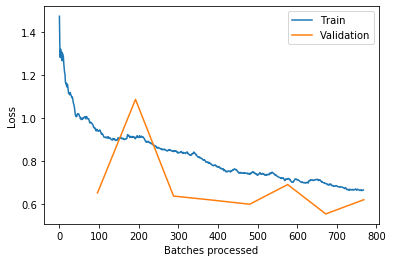

18_448_lr_0.02_cyc_8_i7_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.945276,0.848607,0.279279,0.720721,00:44
1,0.891672,1.012531,0.504505,0.495495,00:44
2,0.830178,0.817736,0.315315,0.684685,00:45
3,0.777974,1.087052,0.454955,0.545045,00:44
4,0.728453,0.883191,0.306306,0.693694,00:44
5,0.704749,0.633607,0.220721,0.779279,00:43
6,0.703476,0.572283,0.144144,0.855856,00:44
7,0.679621,0.609681,0.175676,0.824324,00:46


Better model found at epoch 0 with accuracy value: 0.7207207083702087.
Better model found at epoch 5 with accuracy value: 0.7792792916297913.
Better model found at epoch 6 with accuracy value: 0.8558558821678162.


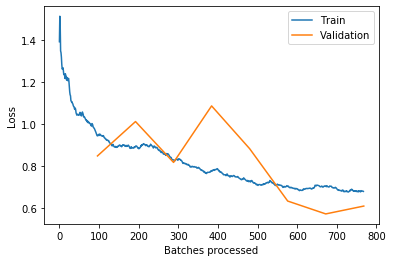

18_448_lr_0.02_cyc_8_i8_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.912201,0.720282,0.234234,0.765766,00:44
1,0.890281,1.310387,0.617117,0.382883,00:44
2,0.843264,0.822058,0.342342,0.657658,00:44
3,0.783472,0.647658,0.247748,0.752252,00:44
4,0.761563,0.880918,0.274775,0.725225,00:44
5,0.725744,0.644239,0.193694,0.806306,00:44
6,0.688206,0.598271,0.175676,0.824324,00:44
7,0.672277,0.692430,0.229730,0.770270,00:44


Better model found at epoch 0 with accuracy value: 0.7657657861709595.
Better model found at epoch 5 with accuracy value: 0.8063063025474548.
Better model found at epoch 6 with accuracy value: 0.8243243098258972.


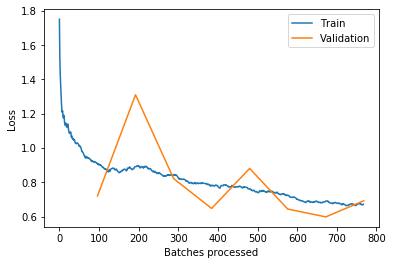

18_448_lr_0.02_cyc_8_i9_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.965374,0.800963,0.256757,0.743243,00:43
1,0.898107,1.459609,0.599099,0.400901,00:44
2,0.847826,0.836980,0.292793,0.707207,00:44
3,0.802368,0.792728,0.279279,0.720721,00:44
4,0.766236,0.951790,0.432432,0.567568,00:44
5,0.734210,0.553326,0.144144,0.855856,00:44
6,0.698059,0.608988,0.189189,0.810811,00:45
7,0.676609,0.625875,0.198198,0.801802,00:45


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 5 with accuracy value: 0.8558558821678162.


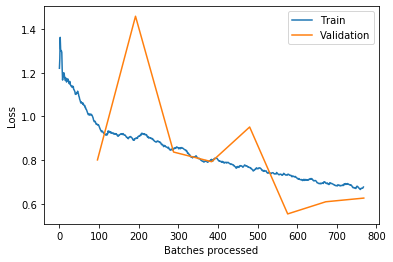

saved stats to: stats\18_448_stats.p


In [45]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [46]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.113  med: 0.176   Loss -- best: 0.420  med: 0.631

18_448_lr_0.02_cyc_8_i7  error_rate: 0.113   accuracy: 0.887   loss:0.4697
18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.01_cyc_12_i3  error_rate: 0.122   accuracy: 0.878   loss:0.4432
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_12_i8  error_rate: 0.126   accuracy: 0.874   loss:0.5229
18_448_lr_0.02_cyc_8_i6_m  error_rate: 0.126   accuracy: 0.874   loss:0.5550
18_448_lr_0.02_cyc_8_i6  error_rate: 0.126   accuracy: 0.874   loss:0.5788
18_448_lr_0.01_cyc_8_i3  error_rate: 0.131   accuracy: 0.869   loss:0.5154


18_448_lr_0.02_cyc_16_i0_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.963534,0.708325,0.270270,0.729730,00:44
1,0.855934,0.962937,0.319820,0.680180,00:44
2,0.864907,0.970228,0.378378,0.621622,00:44
3,0.837496,1.234766,0.432432,0.567568,00:44
4,0.786604,0.623103,0.319820,0.680180,00:44
5,0.770989,0.854763,0.351351,0.648649,00:44
6,0.754024,1.204850,0.608108,0.391892,00:44
7,0.785580,0.667406,0.211712,0.788288,00:44
8,0.745326,0.604696,0.252252,0.747748,00:43
9,0.715109,0.799706,0.283784,0.716216,00:44


Better model found at epoch 0 with accuracy value: 0.7297297120094299.
Better model found at epoch 7 with accuracy value: 0.7882882952690125.
Better model found at epoch 13 with accuracy value: 0.8018018007278442.
Better model found at epoch 14 with accuracy value: 0.8063063025474548.


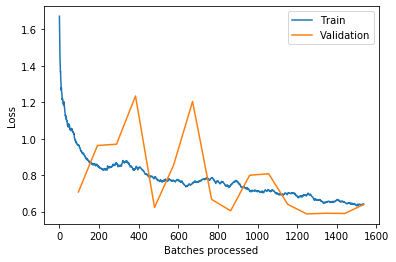

18_448_lr_0.02_cyc_16_i1_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.953744,0.743496,0.234234,0.765766,00:44
1,0.822565,0.779712,0.310811,0.689189,00:43
2,0.857044,0.536893,0.175676,0.824324,00:43
3,0.831671,0.993576,0.405405,0.594595,00:44
4,0.806870,0.569447,0.189189,0.810811,00:43
5,0.772465,0.618820,0.207207,0.792793,00:43
6,0.756963,1.463421,0.513514,0.486486,00:44
7,0.752043,0.595781,0.211712,0.788288,00:43
8,0.742938,1.192231,0.382883,0.617117,00:44
9,0.739215,0.498933,0.189189,0.810811,00:44


Better model found at epoch 0 with accuracy value: 0.7657657861709595.
Better model found at epoch 2 with accuracy value: 0.8243243098258972.


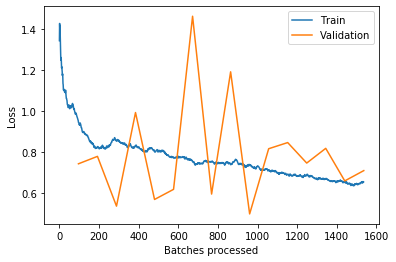

18_448_lr_0.02_cyc_16_i2_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.934213,0.811054,0.297297,0.702703,00:44
1,0.834699,0.853144,0.270270,0.729730,00:45
2,0.848449,0.783624,0.319820,0.680180,00:44
3,0.838852,0.780479,0.337838,0.662162,00:44
4,0.796375,0.581520,0.189189,0.810811,00:44
5,0.773017,0.693003,0.202703,0.797297,00:44
6,0.773340,0.787132,0.418919,0.581081,00:44
7,0.780922,0.836308,0.387387,0.612613,00:44
8,0.744216,0.527378,0.144144,0.855856,00:44
9,0.718362,0.883039,0.319820,0.680180,00:44


Better model found at epoch 0 with accuracy value: 0.7027027010917664.
Better model found at epoch 1 with accuracy value: 0.7297297120094299.
Better model found at epoch 4 with accuracy value: 0.8108108043670654.
Better model found at epoch 8 with accuracy value: 0.8558558821678162.
Better model found at epoch 11 with accuracy value: 0.8648648858070374.


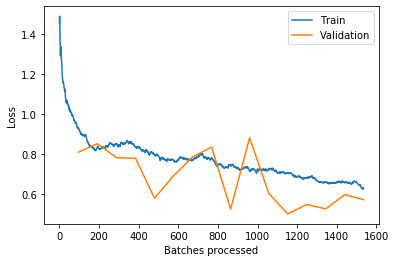

18_448_lr_0.02_cyc_16_i3_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.948689,0.705911,0.270270,0.729730,00:43
1,0.840970,0.708078,0.270270,0.729730,00:43
2,0.859437,0.655356,0.256757,0.743243,00:44
3,0.822535,1.052344,0.554054,0.445946,00:44
4,0.785517,0.559064,0.189189,0.810811,00:44
5,0.788772,0.799341,0.283784,0.716216,00:44
6,0.766446,0.931289,0.387387,0.612613,00:43
7,0.759596,0.796738,0.292793,0.707207,00:44
8,0.742897,0.900887,0.346847,0.653153,00:43
9,0.727009,0.484606,0.148649,0.851351,00:44


Better model found at epoch 0 with accuracy value: 0.7297297120094299.
Better model found at epoch 2 with accuracy value: 0.7432432174682617.
Better model found at epoch 4 with accuracy value: 0.8108108043670654.
Better model found at epoch 9 with accuracy value: 0.8513513803482056.


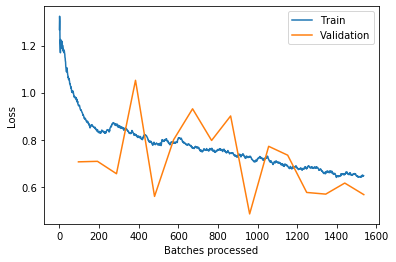

18_448_lr_0.02_cyc_16_i4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.960611,0.651208,0.216216,0.783784,00:44
1,0.832040,0.798521,0.247748,0.752252,00:44
2,0.849570,1.103668,0.387387,0.612613,00:44
3,0.834357,0.628172,0.207207,0.792793,00:43
4,0.796613,0.990434,0.351351,0.648649,00:44
5,0.778035,1.692675,0.626126,0.373874,00:44
6,0.776317,0.541810,0.207207,0.792793,00:43
7,0.777029,0.913002,0.445946,0.554054,00:44
8,0.755299,0.630981,0.171171,0.828829,00:43
9,0.738843,0.619328,0.256757,0.743243,00:44


Better model found at epoch 0 with accuracy value: 0.7837837934494019.
Better model found at epoch 3 with accuracy value: 0.792792797088623.
Better model found at epoch 8 with accuracy value: 0.8288288116455078.
Better model found at epoch 10 with accuracy value: 0.8468468189239502.
Better model found at epoch 12 with accuracy value: 0.8558558821678162.


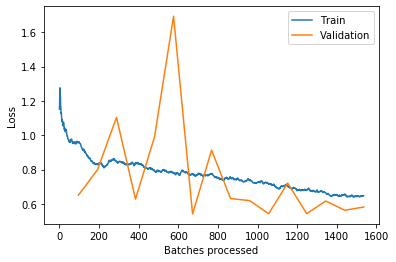

18_448_lr_0.02_cyc_16_i5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.963043,0.776002,0.333333,0.666667,00:44
1,0.848537,1.102786,0.463964,0.536036,00:44
2,0.858974,0.574916,0.288288,0.711712,00:44
3,0.831684,0.769488,0.265766,0.734234,00:43
4,0.779835,0.626322,0.211712,0.788288,00:44
5,0.772993,0.729381,0.310811,0.689189,00:44
6,0.777451,0.606950,0.175676,0.824324,00:43
7,0.755103,0.873280,0.288288,0.711712,00:44
8,0.738955,0.807607,0.319820,0.680180,00:44
9,0.733853,1.193634,0.608108,0.391892,00:44


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 2 with accuracy value: 0.7117117047309875.
Better model found at epoch 3 with accuracy value: 0.7342342138290405.
Better model found at epoch 4 with accuracy value: 0.7882882952690125.
Better model found at epoch 6 with accuracy value: 0.8243243098258972.
Better model found at epoch 14 with accuracy value: 0.837837815284729.
Better model found at epoch 15 with accuracy value: 0.8558558821678162.


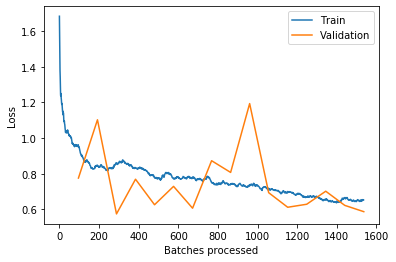

18_448_lr_0.02_cyc_16_i6_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.959649,0.734690,0.279279,0.720721,00:44
1,0.850017,0.809400,0.355856,0.644144,00:44
2,0.877154,0.900847,0.346847,0.653153,00:44
3,0.823345,0.710341,0.265766,0.734234,00:44
4,0.809665,0.857958,0.328829,0.671171,00:44
5,0.774121,0.712355,0.265766,0.734234,00:44
6,0.779054,1.273538,0.545045,0.454955,00:44
7,0.766440,0.768670,0.328829,0.671171,00:44
8,0.753213,0.542531,0.162162,0.837838,00:44
9,0.733199,0.515609,0.135135,0.864865,00:44


Better model found at epoch 0 with accuracy value: 0.7207207083702087.
Better model found at epoch 3 with accuracy value: 0.7342342138290405.
Better model found at epoch 8 with accuracy value: 0.837837815284729.
Better model found at epoch 9 with accuracy value: 0.8648648858070374.


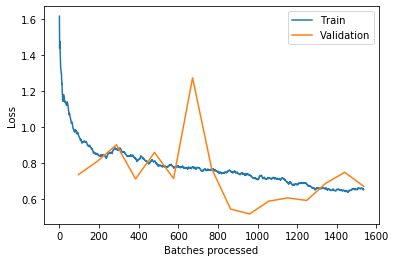

18_448_lr_0.02_cyc_16_i7_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.951645,0.745943,0.252252,0.747748,00:44
1,0.838485,0.868843,0.306306,0.693694,00:47
2,0.843047,0.924805,0.418919,0.581081,00:43
3,0.846113,0.660369,0.292793,0.707207,00:44
4,0.791413,0.472253,0.180180,0.819820,00:46
5,0.781428,0.647851,0.229730,0.770270,00:46
6,0.772532,0.689834,0.225225,0.774775,00:46
7,0.745757,0.556908,0.211712,0.788288,00:45
8,0.740340,0.623019,0.166667,0.833333,00:47
9,0.740345,0.713442,0.261261,0.738739,00:46


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 4 with accuracy value: 0.8198198080062866.
Better model found at epoch 8 with accuracy value: 0.8333333134651184.
Better model found at epoch 10 with accuracy value: 0.869369387626648.


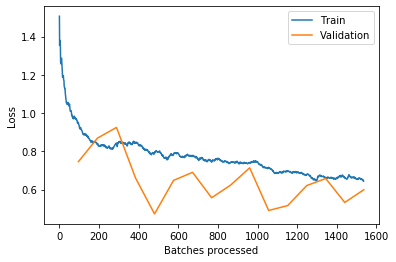

18_448_lr_0.02_cyc_16_i8_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.938456,0.718006,0.234234,0.765766,00:44
1,0.839833,0.654684,0.243243,0.756757,00:44
2,0.852165,0.902820,0.391892,0.608108,00:45
3,0.828561,0.658771,0.220721,0.779279,00:46
4,0.825537,0.603418,0.211712,0.788288,00:44
5,0.796147,0.976113,0.378378,0.621622,00:44
6,0.800498,0.565630,0.162162,0.837838,00:44
7,0.745111,1.401713,0.576577,0.423423,00:45
8,0.751569,0.858106,0.274775,0.725225,00:44
9,0.731978,0.699369,0.265766,0.734234,00:43


Better model found at epoch 0 with accuracy value: 0.7657657861709595.
Better model found at epoch 3 with accuracy value: 0.7792792916297913.
Better model found at epoch 4 with accuracy value: 0.7882882952690125.
Better model found at epoch 6 with accuracy value: 0.837837815284729.


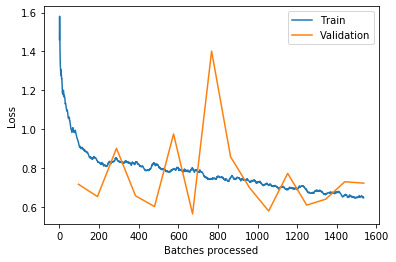

18_448_lr_0.02_cyc_16_i9_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.954888,0.666368,0.270270,0.729730,00:44
1,0.846680,0.562818,0.171171,0.828829,00:45
2,0.850262,0.816556,0.360360,0.639640,00:44
3,0.820786,1.447264,0.513514,0.486486,00:44
4,0.781385,0.816933,0.310811,0.689189,00:45
5,0.779781,1.202272,0.513514,0.486486,00:44
6,0.761219,1.287063,0.387387,0.612613,00:44
7,0.751771,0.626850,0.243243,0.756757,00:44
8,0.740306,0.770229,0.351351,0.648649,00:44
9,0.722083,0.992444,0.450450,0.549550,00:44


Better model found at epoch 0 with accuracy value: 0.7297297120094299.
Better model found at epoch 1 with accuracy value: 0.8288288116455078.


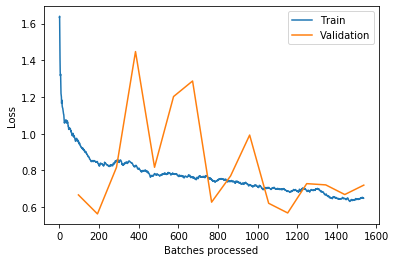

saved stats to: stats\18_448_stats.p


In [47]:
for i in range(10):
    for key, params in get_params(all_cycles=[16], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [48]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.113  med: 0.176   Loss -- best: 0.420  med: 0.621

18_448_lr_0.02_cyc_8_i7  error_rate: 0.113   accuracy: 0.887   loss:0.4697
18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.01_cyc_12_i3  error_rate: 0.122   accuracy: 0.878   loss:0.4432
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_12_i8  error_rate: 0.126   accuracy: 0.874   loss:0.5229
18_448_lr_0.02_cyc_8_i6_m  error_rate: 0.126   accuracy: 0.874   loss:0.5550
18_448_lr_0.02_cyc_8_i6  error_rate: 0.126   accuracy: 0.874   loss:0.5788
18_448_lr_0.01_cyc_8_i3  error_rate: 0.131   accuracy: 0.869   loss:0.5154


18_448_lr_0.03_cyc_8_i0_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.933998,0.907944,0.364865,0.635135,00:45
1,0.975470,0.788915,0.396396,0.603604,00:44
2,0.888391,0.788883,0.324324,0.675676,00:44
3,0.840841,2.129802,0.657658,0.342342,00:45
4,0.813523,0.685108,0.193694,0.806306,00:44
5,0.759437,0.723123,0.234234,0.765766,00:45
6,0.712144,0.684692,0.229730,0.770270,00:45
7,0.692381,0.606968,0.166667,0.833333,00:44


Better model found at epoch 0 with accuracy value: 0.6351351141929626.
Better model found at epoch 2 with accuracy value: 0.6756756901741028.
Better model found at epoch 4 with accuracy value: 0.8063063025474548.
Better model found at epoch 7 with accuracy value: 0.8333333134651184.


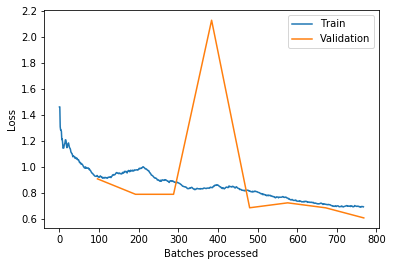

18_448_lr_0.03_cyc_8_i1_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.949325,0.804517,0.279279,0.720721,00:45
1,0.947725,2.283811,0.630631,0.369369,00:45
2,0.868557,0.581856,0.225225,0.774775,00:44
3,0.795234,1.151456,0.400901,0.599099,00:45
4,0.749207,0.882647,0.364865,0.635135,00:44
5,0.738532,0.546338,0.157658,0.842342,00:44
6,0.682618,0.651997,0.225225,0.774775,00:45
7,0.682518,0.688212,0.247748,0.752252,00:45


Better model found at epoch 0 with accuracy value: 0.7207207083702087.
Better model found at epoch 2 with accuracy value: 0.7747747898101807.
Better model found at epoch 5 with accuracy value: 0.8423423171043396.


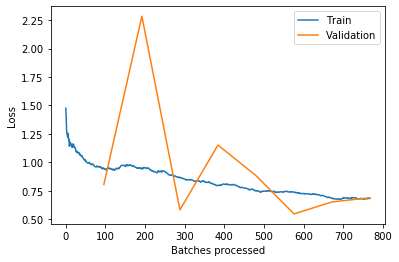

18_448_lr_0.03_cyc_8_i2_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.911224,1.022935,0.400901,0.599099,00:44
1,0.937295,0.846615,0.328829,0.671171,00:45
2,0.878717,0.771335,0.283784,0.716216,00:44
3,0.824200,0.829087,0.427928,0.572072,00:44
4,0.791709,0.573866,0.256757,0.743243,00:44
5,0.739498,0.987071,0.369369,0.630631,00:44
6,0.711814,0.801059,0.252252,0.747748,00:44
7,0.689701,0.801975,0.283784,0.716216,00:44


Better model found at epoch 0 with accuracy value: 0.5990990996360779.
Better model found at epoch 1 with accuracy value: 0.6711711883544922.
Better model found at epoch 2 with accuracy value: 0.7162162065505981.
Better model found at epoch 4 with accuracy value: 0.7432432174682617.
Better model found at epoch 6 with accuracy value: 0.7477477192878723.


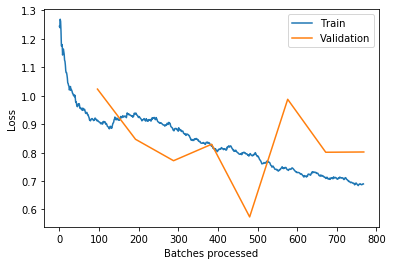

18_448_lr_0.03_cyc_8_i3_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.919830,0.816244,0.355856,0.644144,00:44
1,0.934446,0.861860,0.382883,0.617117,00:44
2,0.877456,0.745652,0.270270,0.729730,00:44
3,0.818247,0.964450,0.346847,0.653153,00:43
4,0.770825,0.649348,0.247748,0.752252,00:43
5,0.751249,0.687597,0.184685,0.815315,00:44
6,0.714468,0.648351,0.207207,0.792793,00:43
7,0.686524,0.696299,0.211712,0.788288,00:44


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 2 with accuracy value: 0.7297297120094299.
Better model found at epoch 4 with accuracy value: 0.7522522807121277.
Better model found at epoch 5 with accuracy value: 0.815315306186676.


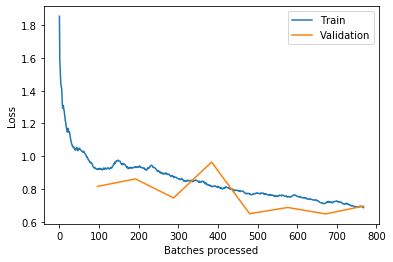

18_448_lr_0.03_cyc_8_i4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.933400,0.592523,0.207207,0.792793,00:44
1,0.956833,0.826962,0.477477,0.522523,00:43
2,0.874428,0.689367,0.153153,0.846847,00:44
3,0.833172,1.096266,0.364865,0.635135,00:44
4,0.819056,0.735592,0.337838,0.662162,00:44
5,0.767337,0.732369,0.265766,0.734234,00:44
6,0.715287,0.662567,0.220721,0.779279,00:44
7,0.695002,0.606298,0.202703,0.797297,00:47


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 2 with accuracy value: 0.8468468189239502.


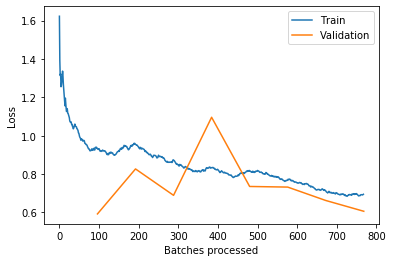

18_448_lr_0.03_cyc_8_i5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.913164,0.886796,0.396396,0.603604,00:45
1,0.916578,0.670139,0.247748,0.752252,00:45
2,0.859121,1.924932,0.463964,0.536036,00:45
3,0.812158,0.877407,0.342342,0.657658,00:45
4,0.777337,0.629170,0.234234,0.765766,00:45
5,0.726212,0.845597,0.283784,0.716216,00:44
6,0.718378,0.650171,0.198198,0.801802,00:44
7,0.675611,0.727732,0.247748,0.752252,00:44


Better model found at epoch 0 with accuracy value: 0.6036036014556885.
Better model found at epoch 1 with accuracy value: 0.7522522807121277.
Better model found at epoch 4 with accuracy value: 0.7657657861709595.
Better model found at epoch 6 with accuracy value: 0.8018018007278442.


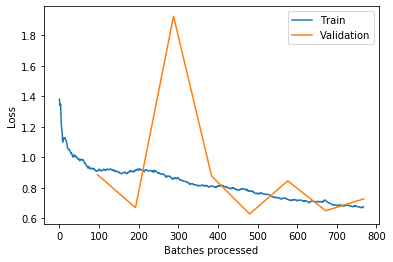

18_448_lr_0.03_cyc_8_i6_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.946793,1.026293,0.432432,0.567568,00:45
1,0.918787,1.274055,0.563063,0.436937,00:44
2,0.843849,0.855812,0.337838,0.662162,00:45
3,0.800392,0.648965,0.283784,0.716216,00:44
4,0.772182,0.473736,0.157658,0.842342,00:45
5,0.736106,0.583172,0.153153,0.846847,00:44
6,0.689858,0.641016,0.189189,0.810811,00:44
7,0.665466,0.695764,0.234234,0.765766,00:45


Better model found at epoch 0 with accuracy value: 0.5675675868988037.
Better model found at epoch 2 with accuracy value: 0.662162184715271.
Better model found at epoch 3 with accuracy value: 0.7162162065505981.
Better model found at epoch 4 with accuracy value: 0.8423423171043396.
Better model found at epoch 5 with accuracy value: 0.8468467593193054.


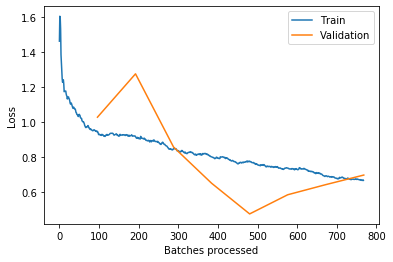

18_448_lr_0.03_cyc_8_i7_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.942362,0.732777,0.261261,0.738739,00:45
1,0.942751,1.624796,0.495495,0.504505,00:44
2,0.875145,1.058607,0.468468,0.531532,00:45
3,0.830118,0.690938,0.279279,0.720721,00:44
4,0.764679,0.680615,0.216216,0.783784,00:45
5,0.733845,0.476378,0.126126,0.873874,00:45
6,0.708280,0.632875,0.211712,0.788288,00:45
7,0.684568,0.647011,0.184685,0.815315,00:44


Better model found at epoch 0 with accuracy value: 0.7387387156486511.
Better model found at epoch 4 with accuracy value: 0.7837837934494019.
Better model found at epoch 5 with accuracy value: 0.8738738894462585.


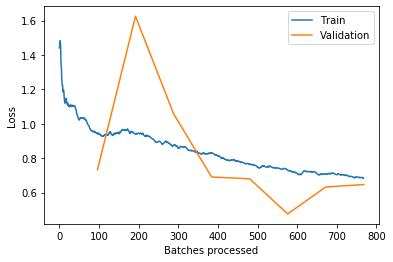

18_448_lr_0.03_cyc_8_i8_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.899754,0.682368,0.274775,0.725225,00:44
1,0.914189,1.788829,0.603604,0.396396,00:44
2,0.853099,0.638079,0.225225,0.774775,00:44
3,0.837029,0.651651,0.229730,0.770270,00:45
4,0.770775,1.184696,0.441441,0.558559,00:45
5,0.738242,0.824433,0.301802,0.698198,00:44
6,0.704624,0.712247,0.225225,0.774775,00:45
7,0.672726,0.698227,0.225225,0.774775,00:44


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 2 with accuracy value: 0.7747747898101807.


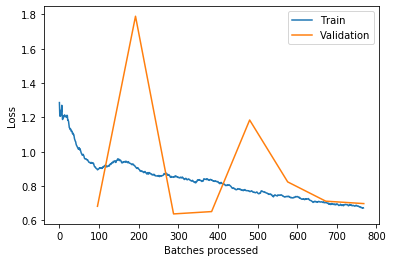

18_448_lr_0.03_cyc_8_i9_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.917150,0.833718,0.364865,0.635135,00:45
1,0.936002,0.796175,0.351351,0.648649,00:45
2,0.878577,0.607368,0.247748,0.752252,00:44
3,0.826524,0.883857,0.301802,0.698198,00:45
4,0.794288,1.094643,0.400901,0.599099,00:45
5,0.757253,0.564974,0.153153,0.846847,00:44
6,0.720554,0.621644,0.175676,0.824324,00:45
7,0.702499,0.662249,0.216216,0.783784,00:45


Better model found at epoch 0 with accuracy value: 0.6351351141929626.
Better model found at epoch 1 with accuracy value: 0.6486486196517944.
Better model found at epoch 2 with accuracy value: 0.7522522807121277.
Better model found at epoch 5 with accuracy value: 0.8468468189239502.


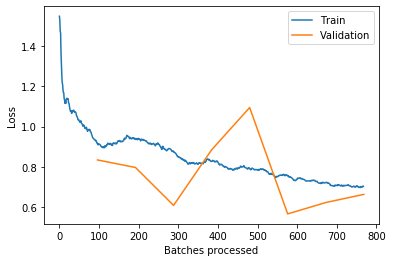

saved stats to: stats\18_448_stats.p


In [49]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [50]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.113  med: 0.173   Loss -- best: 0.420  med: 0.621

18_448_lr_0.02_cyc_8_i7  error_rate: 0.113   accuracy: 0.887   loss:0.4697
18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.01_cyc_12_i3  error_rate: 0.122   accuracy: 0.878   loss:0.4432
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_12_i8  error_rate: 0.126   accuracy: 0.874   loss:0.5229
18_448_lr_0.02_cyc_8_i6_m  error_rate: 0.126   accuracy: 0.874   loss:0.5550
18_448_lr_0.03_cyc_8_i7_m  error_rate: 0.126   accuracy: 0.874   loss:0.4764
18_448_lr_0.02_cyc_8_i6  error_rate: 0.126   accuracy: 0.874   loss:0.5788


In [ ]:
for key, params in get_params(all_cycles=[16], all_lr=[1e-3, 3e-4, 1e-4]):
    for ps in [0.5, 0.8, 0.85, 0.9]:
        do_train(key, mixup=True, ps=ps, **params)
all_stats.save()

18_448_lr_0.001_cyc_16_ps_0.5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.209729,0.689104,0.274775,0.725225,00:45
1,1.034466,0.572198,0.175676,0.824324,00:44
2,0.929518,0.605588,0.198198,0.801802,00:45
3,0.862937,0.669007,0.265766,0.734234,00:45
4,0.811185,0.704792,0.216216,0.783784,00:45
5,0.770435,0.680974,0.193694,0.806306,00:45
6,0.738686,0.707733,0.198198,0.801802,00:45
7,0.717423,0.718252,0.225225,0.774775,00:45
8,0.707023,0.734501,0.225225,0.774775,00:45
9,0.696670,0.736740,0.220721,0.779279,00:45


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 1 with accuracy value: 0.8243243098258972.


In [ ]:
show_results(all_stats.get(), limit=10)

## Summary of Results

In [22]:
for key in [None, 'lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12',  'cyc_16', 
            '_m', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, show_details=False)

Overall         Error -- best: 0.113  med: 0.173   Loss -- best: 0.420  med: 0.621
lr_0.03         Error -- best: 0.126  med: 0.173   Loss -- best: 0.445  med: 0.610
lr_0.02         Error -- best: 0.113  med: 0.169   Loss -- best: 0.470  med: 0.570
lr_0.01         Error -- best: 0.122  med: 0.169   Loss -- best: 0.420  med: 0.565
lr_0.003        Error -- best: 0.144  med: 0.194   Loss -- best: 0.538  med: 0.655
lr_0.001        Error -- best: 0.162  med: 0.189   Loss -- best: 0.634  med: 0.690
lr_0.0003       Error -- best: 0.153  med: 0.185   Loss -- best: 0.539  med: 0.632
lr_0.0001       Error -- best: 0.171  med: 0.227   Loss -- best: 0.619  med: 0.672
cyc_4           Error -- best: 0.140  med: 0.203   Loss -- best: 0.470  med: 0.666
cyc_8           Error -- best: 0.113  med: 0.162   Loss -- best: 0.420  med: 0.572
cyc_12          Error -- best: 0.122  med: 0.146   Loss -- best: 0.443  med: 0.518
cyc_16          Error -- best: 0.131  med: 0.169   Loss -- best: 0.485  med: 0.596
_m  

In [23]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.113  med: 0.173   Loss -- best: 0.420  med: 0.621

18_448_lr_0.02_cyc_8_i7  error_rate: 0.113   accuracy: 0.887   loss:0.4697
18_448_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4200
18_448_lr_0.01_cyc_12_i3  error_rate: 0.122   accuracy: 0.878   loss:0.4432
18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.01_cyc_8_i2  error_rate: 0.126   accuracy: 0.874   loss:0.5221
18_448_lr_0.01_cyc_8_i5  error_rate: 0.126   accuracy: 0.874   loss:0.4555
18_448_lr_0.01_cyc_12_i8  error_rate: 0.126   accuracy: 0.874   loss:0.5229
18_448_lr_0.02_cyc_8_i6_m  error_rate: 0.126   accuracy: 0.874   loss:0.5550
18_448_lr_0.03_cyc_8_i7_m  error_rate: 0.126   accuracy: 0.874   loss:0.4764
18_448_lr_0.02_cyc_8_i6  error_rate: 0.126   accuracy: 0.874   loss:0.5788


In [24]:
for key in ['lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12', 'cyc_16', 
            '_m', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, limit=6)
    print('\n')

lr_0.03         Error -- best: 0.126  med: 0.173   Loss -- best: 0.445  med: 0.610

18_448_lr_0.03_cyc_8  error_rate: 0.126   accuracy: 0.874   loss:0.4446
18_448_lr_0.03_cyc_8_i7_m  error_rate: 0.126   accuracy: 0.874   loss:0.4764
18_448_lr_0.03_cyc_4_i6  error_rate: 0.140   accuracy: 0.860   loss:0.4701
18_448_lr_0.03_cyc_8_i4  error_rate: 0.149   accuracy: 0.851   loss:0.5345
18_448_lr_0.03_cyc_8_i1  error_rate: 0.149   accuracy: 0.851   loss:0.5973
18_448_lr_0.03_cyc_8_i6  error_rate: 0.153   accuracy: 0.847   loss:0.5463


lr_0.02         Error -- best: 0.113  med: 0.169   Loss -- best: 0.470  med: 0.570

18_448_lr_0.02_cyc_8_i7  error_rate: 0.113   accuracy: 0.887   loss:0.4697
18_448_lr_0.02_cyc_8_i6_m  error_rate: 0.126   accuracy: 0.874   loss:0.5550
18_448_lr_0.02_cyc_8_i6  error_rate: 0.126   accuracy: 0.874   loss:0.5788
18_448_lr_0.02_cyc_8_i0_m  error_rate: 0.131   accuracy: 0.869   loss:0.5419
18_448_lr_0.02_cyc_8_i3_m  error_rate: 0.131   accuracy: 0.869   loss:0.5167


In [ ]:
assert False

## Inference

- try composite of 4 learners
- try test-time augmentation
- Includes results for both Validation and Test Datasets

### Examine Best Classifier vased on lowest error rate

In [50]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
name = top_results[0]
print(name)

18_448_lr_0.02_cyc_8_i7



18_448_lr_0.02_cyc_8_i7 Validation tta=False
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        88%         96%        93%        0.92
normal          97%         82%        99%        0.89
virus           83%         88%        91%        0.86


Overall Accuracy: 88.74%


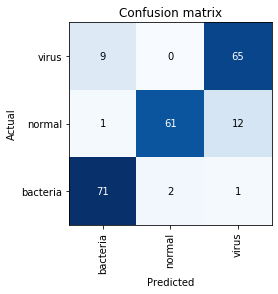

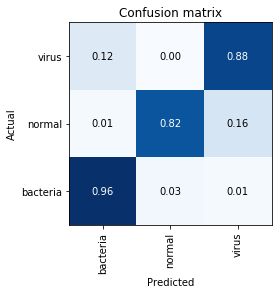

In [51]:
interp = get_interp(name)
print(f'\n{name} Validation tta=False')
analyze_interp(interp)


18_448_lr_0.02_cyc_8_i7 Test tta=False
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        87%        100%        93%        0.93
normal          99%         92%        99%        0.95
virus           91%         84%        96%        0.87


Overall Accuracy: 91.89%


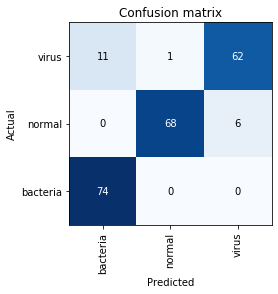

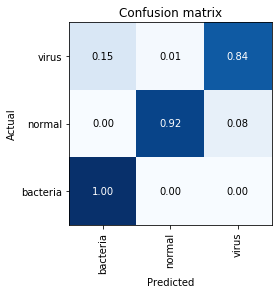

In [52]:
interp = get_interp_test(name)
print(f'\n{name} Test tta=False')
analyze_interp(interp)

#### Use TTA


18_448_lr_0.02_cyc_8_i7 Validation tta=True
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        91%         95%        95%        0.93
normal          94%         81%        97%        0.87
virus           83%         91%        91%        0.86


Overall Accuracy: 88.74%


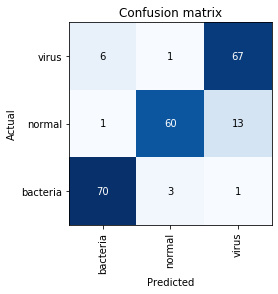

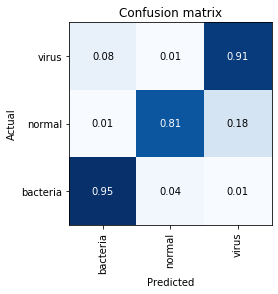

In [53]:
interp = get_interp(name, use_tta=True)
print(f'\n{name} Validation tta=True')
analyze_interp(interp)


18_448_lr_0.02_cyc_8_i7 Test tta=True
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        88%         96%        93%        0.92
normal          97%         93%        99%        0.95
virus           89%         84%        95%        0.86


Overall Accuracy: 90.99%


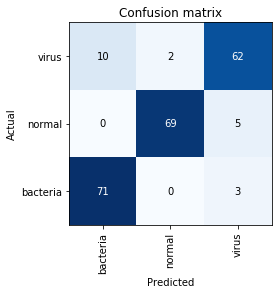

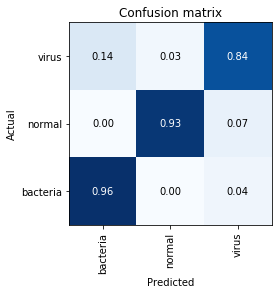

In [54]:
interp = get_interp_test(name, use_tta=True)
print(f'\n{name} Test tta=True')
analyze_interp(interp)

### Composite for Validation based on accuracy

In [35]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

accuracy -- mean: 0.878   median: 0.883   gmean: 0.883   hmean: 0.883


#### Show Individual - for Validation dataset

18_448_lr_0.02_cyc_8_i7
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        88%         96%        93%        0.92
normal          97%         82%        99%        0.89
virus           83%         88%        91%        0.86


Overall Accuracy: 88.74%


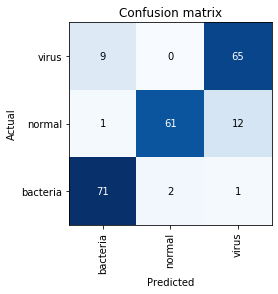

18_448_lr_0.01_cyc_8_i4
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        85%         96%        91%        0.90
normal          88%         93%        94%        0.91
virus           93%         76%        97%        0.84


Overall Accuracy: 88.29%


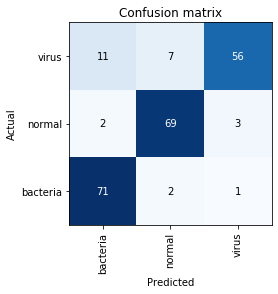

18_448_lr_0.01_cyc_12_i3
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        86%         97%        92%        0.91
normal          98%         78%        99%        0.87
virus           82%         88%        91%        0.85


Overall Accuracy: 87.84%


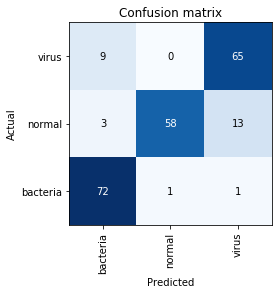

18_448_lr_0.03_cyc_8
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        82%         97%        89%        0.89
normal          96%         86%        98%        0.91
virus           87%         78%        94%        0.82


Overall Accuracy: 87.39%


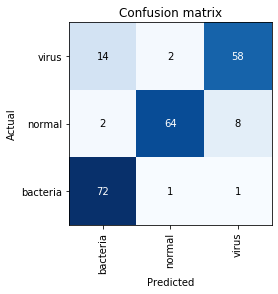

In [33]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

### Composite for Validation based on loss

In [37]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

accuracy -- mean: 0.869   median: 0.883   gmean: 0.869   hmean: 0.874


### Composite for Test based on accuracy

In [48]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.892   median: 0.896   gmean: 0.892   hmean: 0.901


#### Individual results for top 4

18_448_lr_0.02_cyc_8_i7
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        87%        100%        93%        0.93
normal          99%         92%        99%        0.95
virus           91%         84%        96%        0.87


Overall Accuracy: 91.89%


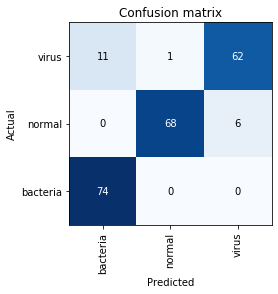

18_448_lr_0.01_cyc_8_i4
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        80%         95%        88%        0.86
normal          83%         96%        90%        0.89
virus           98%         64%        99%        0.77


Overall Accuracy: 84.68%


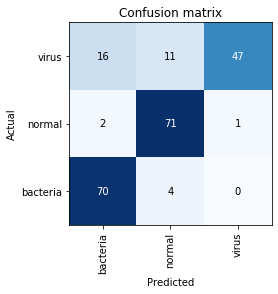

18_448_lr_0.01_cyc_12_i3
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        88%         93%        94%        0.91
normal          96%         92%        98%        0.94
virus           86%         85%        93%        0.86


Overall Accuracy: 90.09%


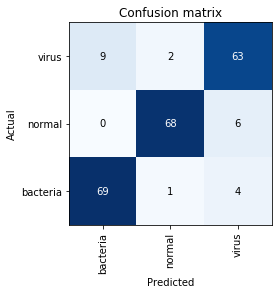

18_448_lr_0.03_cyc_8
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        77%         97%        85%        0.86
normal          92%         92%        96%        0.92
virus           93%         68%        97%        0.78


Overall Accuracy: 85.59%


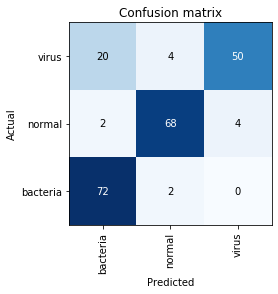

In [39]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

### Composite for Test based on loss

In [49]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.883   median: 0.883   gmean: 0.896   hmean: 0.901


## Experiment with fine tuning classifier

In [ ]:
name = '18_448cut_lr_0.02_cyc_16_i6_m'

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(2e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-4))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-5))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=2)
stats, new_name

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=8)
stats, new_name

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=8)
    foo.append([1, stats])
foo

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=16)
    foo.append([1, stats])
    print('\n')
foo